In [79]:
import pyforest
import sys
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/')
# from updated_RF import *
from RF_functions import *
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem


import math
import torch
import numpy as np
# import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import shutil
import matplotlib 
# matplotlib.use('Agg')

from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

# from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys


from sklearn.model_selection import GridSearchCV

In [8]:
gp_results='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/gp_kfold_results/'

rf_results='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/rf_models/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MOE','MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
folds=['fold1','fold2','fold3','fold4','fold5'] 

In [93]:
rf_kfold_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_kfold_results/'

# rf_kfold_results1 = pd.read_csv(f'{rf_kfold_path}RF_test_results_all_NEK_kfold_val_5x.csv') # same thing as below 
rf_kfold_results1 = pd.read_csv(f'{rf_kfold_path}repeated0-5_RF_test_results_all_NEK_kfold_val_5x.csv')

print(rf_kfold_results1['iteration'].value_counts())

rf_kfold_results2 = pd.read_csv(f'{rf_kfold_path}RF_test_results_all_NEK_kfold_val_5x_6-10.csv')
rf_kfold_results2['iteration'] = rf_kfold_results2['iteration']+5
rf_kfold_results2['model'] = rf_kfold_results2['model'].str[:-1] + (rf_kfold_results2['iteration'].astype(str))
rf_kfold_nersc = pd.concat([rf_kfold_results1, rf_kfold_results2])
rf_kfold_nersc.shape
rf_kfold_nersc.to_csv(f'{rf_kfold_path}RF_test_results_all_NEK_kfold_val_5x_NERSC.csv', index=False)

iteration
0    960
1    960
2    960
3    960
4    960
Name: count, dtype: int64


In [101]:
# RF kfold Results
# rf = pd.read_csv(f'{rf_results}RF_test_results_all_NEK_kfold_val_10x.csv')
rf = rf_kfold_nersc
rf['1-specificity']=1-rf['specificity']
rf['nek type'] = rf['NEK'].astype(str).str.split('_').str[1]

rf=rf.replace('none_scaled', 'no_sampling')


rf_raw = rf[(rf['strategy'] == 'no_sampling') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'SMOTE', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 
total_rf['strategy'] =total_rf['strategy'].astype(str) +'_'+ total_rf['RF_type']


binding_rf = total_rf[total_rf['nek type'] == 'binding'] 
inhib_rf = total_rf[total_rf['nek type'] == 'inhibition'] 


In [102]:
samp_palette={'no_sampling': 'tab:blue', 'UNDER':'tab:orange', 'SMOTE': 'hotpink', 'ADASYN':'tab:red', 
             'no_sampling_RF': 'cornflowerblue', 'no_sampling_RF_BCW': 'lavender', 'UNDER_RF': 'orange', 
             'no_sampling_BRFC': 'blue', 'SMOTE_RF': 'hotpink', 'ADASYN_RF': 'red', 
             'no_sampling_BRFC_BCW': 'black'}

model_types_dict= {'RF': 's', 'GP':'X', 'GP_matern': 'X', 'GP_RBF': 'd' }

In [103]:


gp = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val_10x.csv')
gp['1-specificity']=1-gp['specificity']
gp['nek type'] = gp['NEK'].astype(str).str.split('_').str[1]

gp=gp.replace('none', 'no_sampling')
gp=gp.replace('none_scaled', 'no_sampling')
gp['strategy'] =gp['strategy'].astype(str) +'_'+ gp['kernel_type']
gp['modeling_type'] = gp['kernel_type']
binding_gp = gp[gp['nek type'] == 'binding'] 
inhib_gp = gp[gp['nek type'] == 'inhibition'] 
gp_strategies=['no_sampling_GP_RBF', 'no_sampling_GP_matern', 'UNDER_GP_RBF',
       'UNDER_GP_matern', 'SMOTE_GP_RBF', 'SMOTE_GP_matern',
       'ADASYN_GP_RBF', 'ADASYN_GP_matern']
gen_colors = ['cornflowerblue', 'orange', 'hotpink','red'] 

for kern in ['RBF','matern']: 
    for samp, color in zip(['no_sampling','UNDER','SMOTE','ADASYN'], gen_colors): 
        gp_type = f'{samp}_GP_{kern}'
        samp_palette[gp_type]=color

binding= pd.concat([binding_rf, binding_gp])
inhib= pd.concat([inhib_rf, inhib_gp])
inhib['strategy'].unique()

array(['no_sampling_RF', 'no_sampling_RF_BCW', 'no_sampling_BRFC',
       'no_sampling_BRFC_BCW', 'UNDER_RF', 'SMOTE_RF', 'ADASYN_RF',
       'no_sampling_GP_RBF', 'no_sampling_GP_matern', 'UNDER_GP_RBF',
       'UNDER_GP_matern', 'SMOTE_GP_RBF', 'SMOTE_GP_matern',
       'ADASYN_GP_RBF', 'ADASYN_GP_matern'], dtype=object)

In [100]:
all_data['modeling_type'].value_counts()

modeling_type
RF           4200
GP_RBF       2400
GP_matern    2400
Name: count, dtype: int64

In [98]:
all_data = pd.concat([binding, inhib])


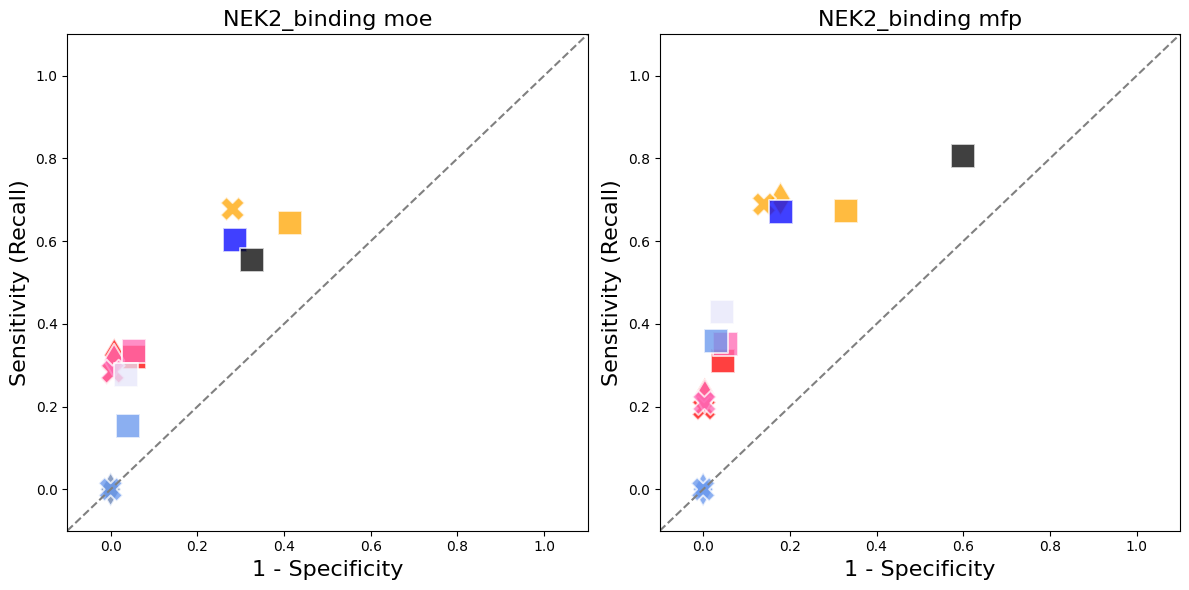

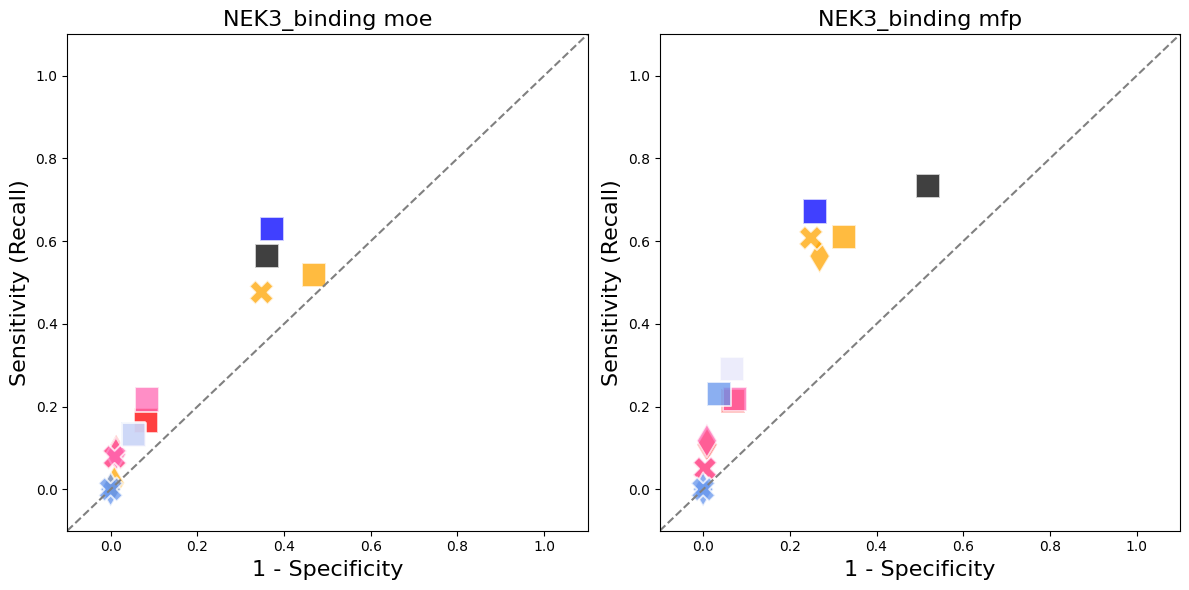

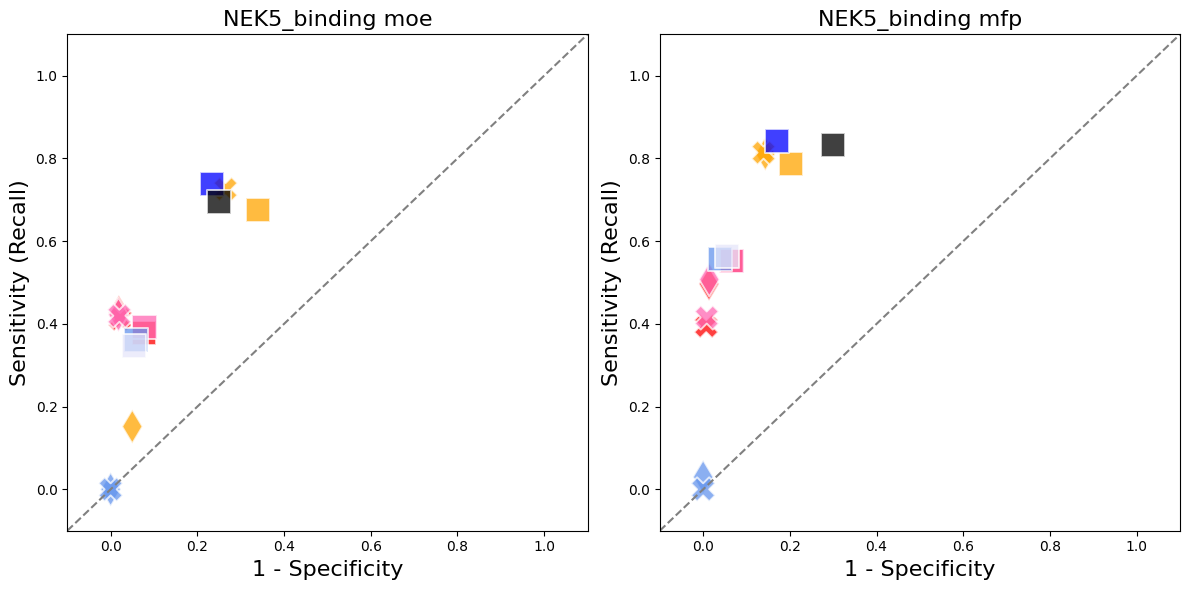

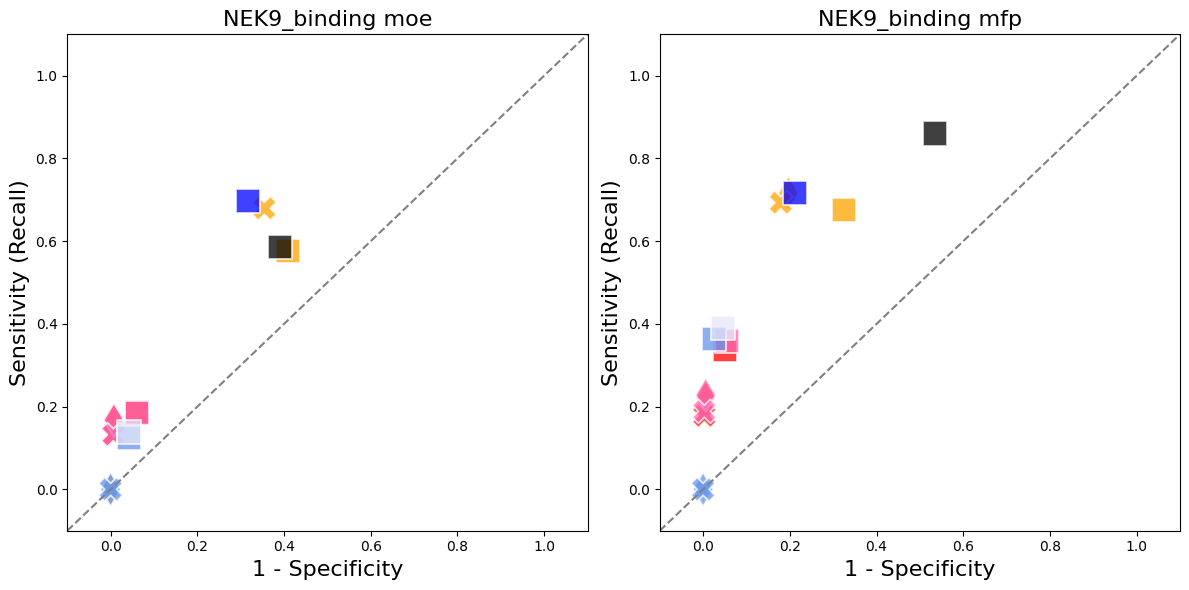

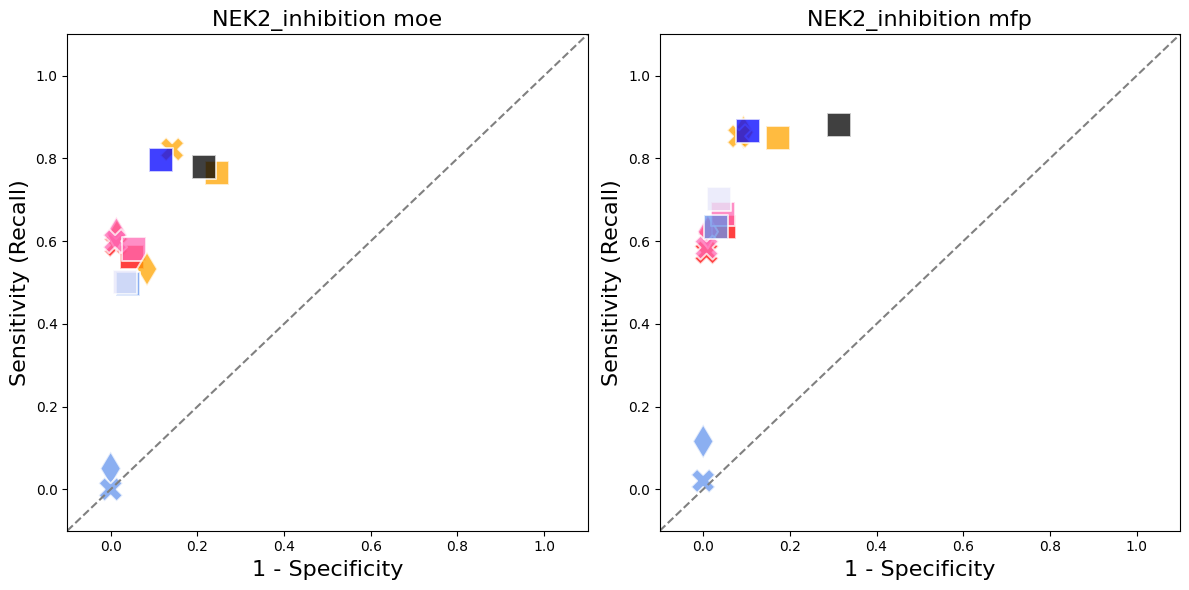

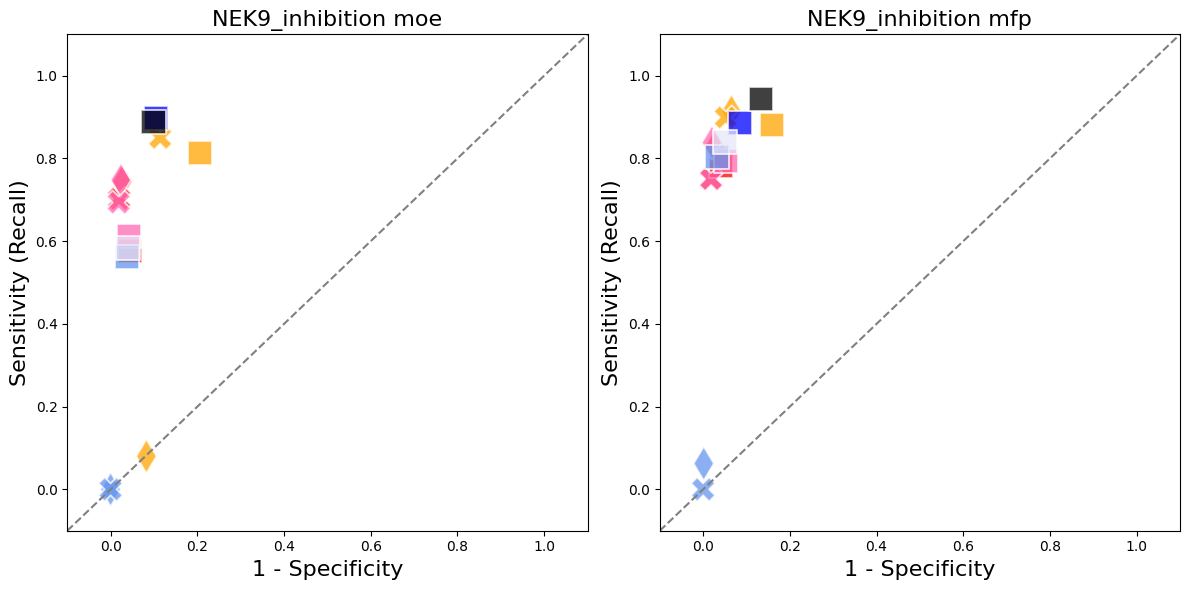

In [115]:
figs='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in all_data['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = all_data[all_data['NEK']==nek]

    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    
    moe_avg = moe_df.groupby(['feat_type', 'strategy','modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    mfp_avg = mfp_df.groupby(['feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    moe_std = moe_df.groupby(['feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index()
    mfp_std = mfp_df.groupby(['feat_type', 'strategy','modeling_type'])[['recall', '1-specificity']].std().reset_index()
    
    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                 markers=model_types_dict,  s=300, alpha=0.75, ax=axs[0], legend=False, palette=samp_palette)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                 markers=model_types_dict, s=300, alpha=0.75, ax=axs[1], legend=False, palette=samp_palette)


    # plt.suptitle(f'{nek} 5fold Results. Average of all 50 iterations\n(err: SD between iterations', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles=handles, labels=labels,
    #            loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    # axs[0].get_legend().remove()
    

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    # plt.savefig(f'{figs}{nek}.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

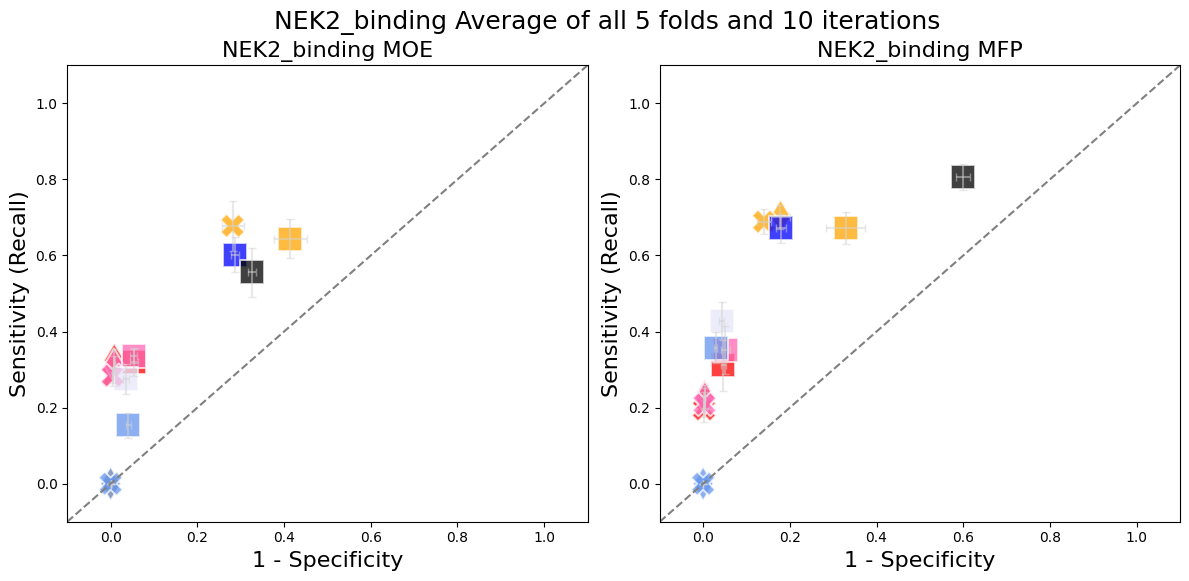

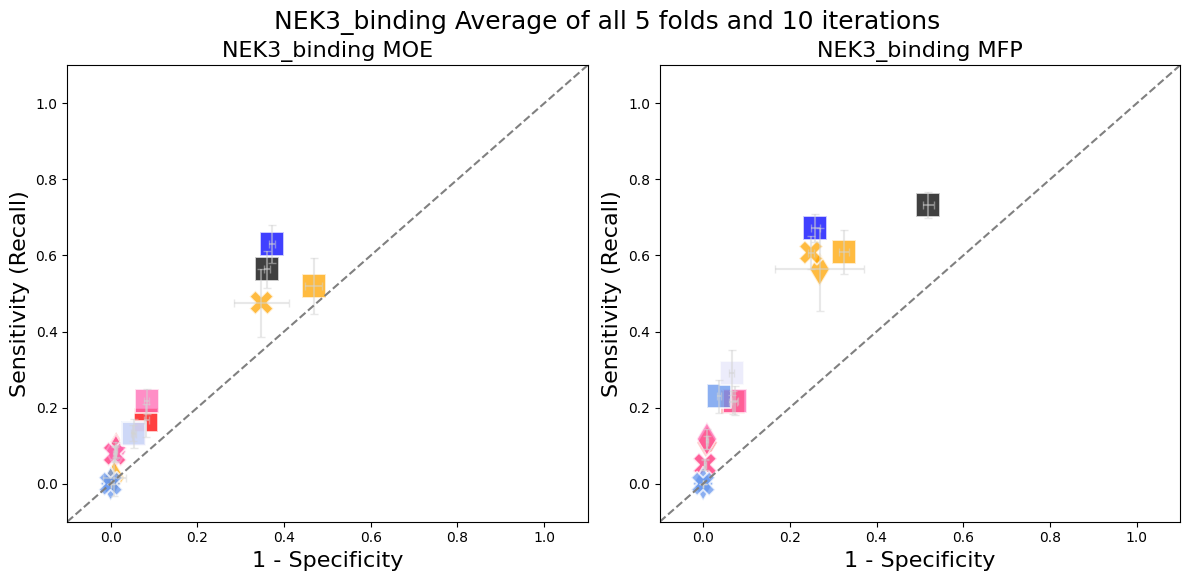

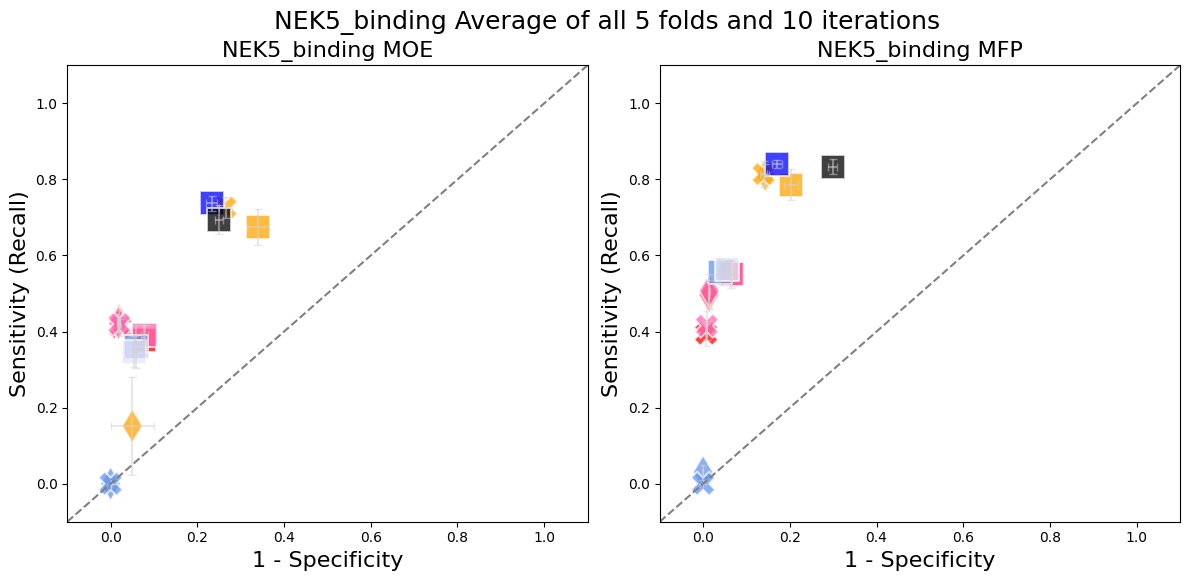

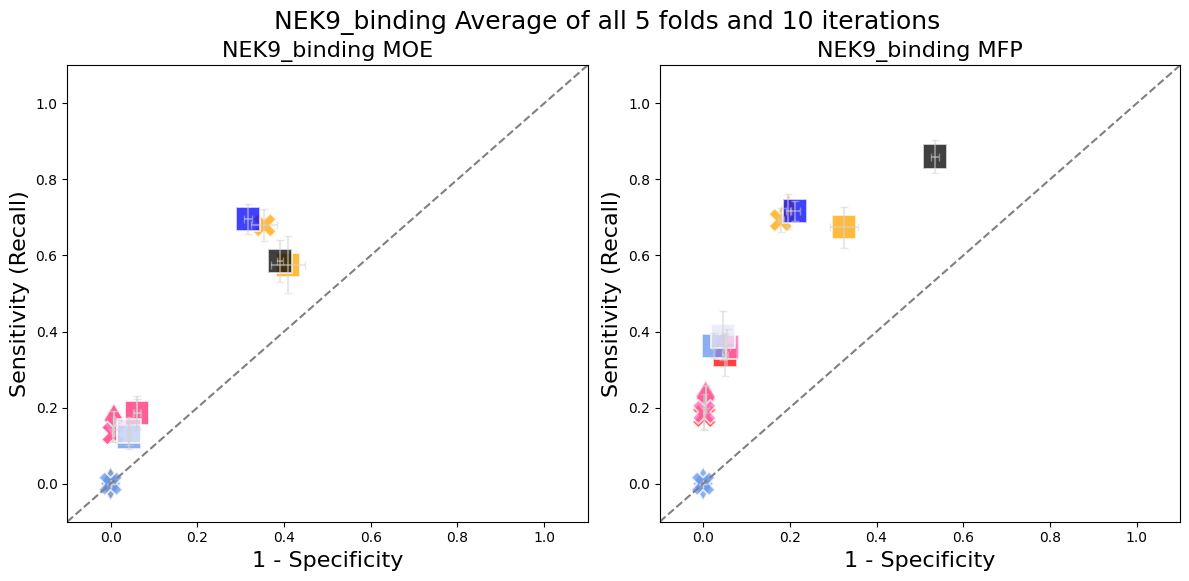

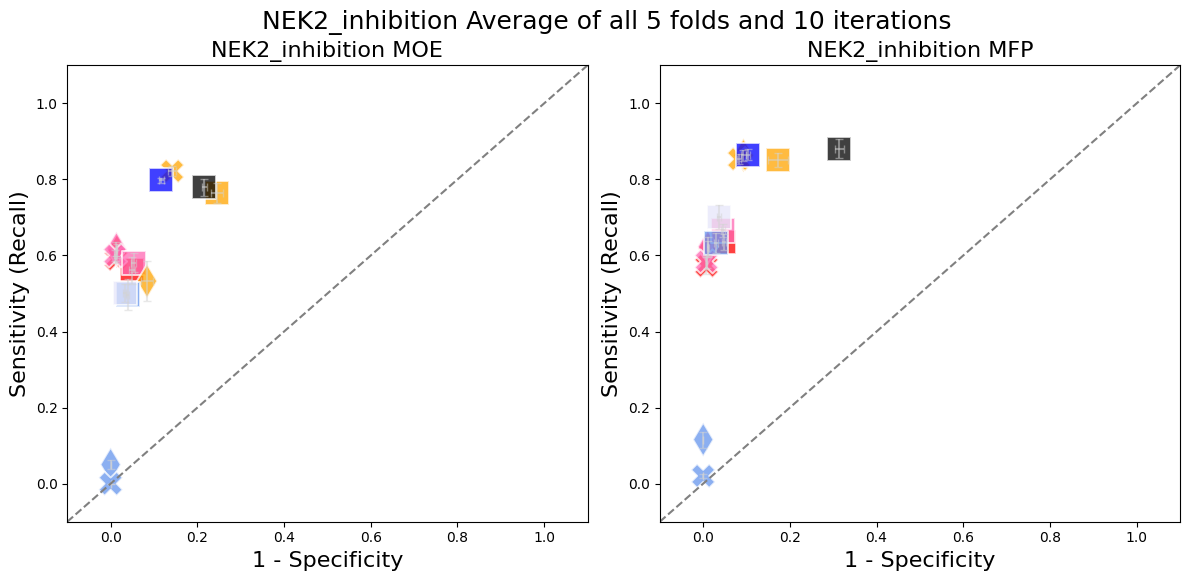

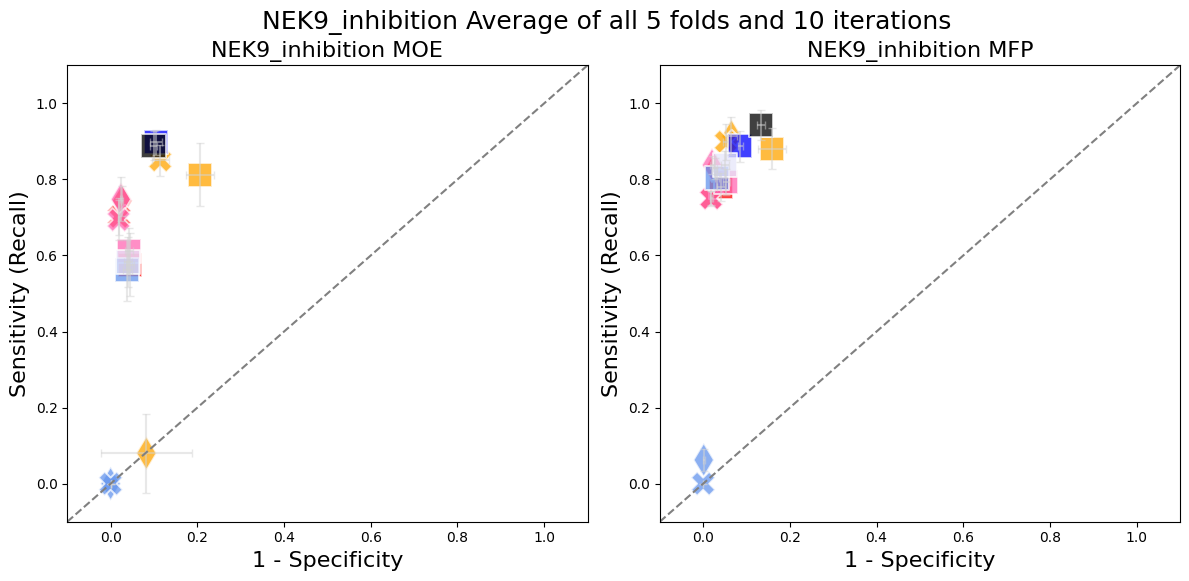

In [111]:
for nek in all_data['NEK'].unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    nek_df = all_data[all_data['NEK'] == nek]
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df = nek_df[nek_df['feat_type'] == 'MFP']
    # for each it 1-10, get average of all 5 folds for that iteration (that model) 
    moe_iter_avg = moe_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    mfp_iter_avg = mfp_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()

    # Compute overall averages and standard deviations across iterations
    # average of all iterations to get std of iterations 
    moe_avg = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index() 
    moe_std = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index() # n =10 

    mfp_avg = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    mfp_std = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index()

    # Scatter plots
    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=0.75, ax=axs[0], legend=False, palette=samp_palette)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=0.75, ax=axs[1], legend=False, palette=samp_palette)

    axs[0].errorbar(x=moe_avg['1-specificity'], y=moe_avg['recall'],
                    xerr=moe_std['1-specificity'], yerr=moe_std['recall'],
                    fmt='none', ecolor='lightgray', alpha=0.5, capsize=3)
    axs[1].errorbar(x=mfp_avg['1-specificity'], y=mfp_avg['recall'],
                    xerr=mfp_std['1-specificity'], yerr=mfp_std['recall'],
                    fmt='none', ecolor='lightgray', alpha=0.5, capsize=3)


    plt.suptitle(f'{nek} Average of all 5 folds and 10 iterations', fontsize=18, x=0.51, y=0.96)
    for i, ax in enumerate(axs):
        ax.plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel('1 - Specificity', fontsize=16)
        ax.set_ylabel('Sensitivity (Recall)', fontsize=16)

    axs[0].set_title(f'{nek} MOE', fontsize=16)
    axs[1].set_title(f'{nek} MFP', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles=handles, labels=labels,
    #            loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=2, fontsize=12)
    raw_RF_BCW = Line2D([0], [0], color='lavender', marker='s', markersize=15, linestyle='None', markerfacecolor='lavender', markeredgewidth=0, label='nosamp RF BalWeight')
    raw_BRFC = Line2D([0], [0], color='blue', marker='s', markersize=15, linestyle='None', markerfacecolor='blue', markeredgewidth=0, label='nosamp Bstrp Under')
    raw_BRFC_BCW = Line2D([0], [0], color='black', marker='s', markersize=15, linestyle='None', markerfacecolor='black', markeredgewidth=0, label='nosamp Bstrp Under BalWeight')
    UNDER_RF = Line2D([0], [0], color='tab:orange', marker='s', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER RF')
    ADASYN_RF = Line2D([0], [0], color='tab:red', marker='s', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN RF')
    raw_RF =  Line2D([0], [0], color='cornflowerblue', marker='s', markersize=15, linestyle='None', markerfacecolor='cornflowerblue', markeredgewidth=0, label='nosamp RF')
    UNDER_GP_matern = Line2D([0],[0], color='tab:orange', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER GP matern')
    UNDER_GP_RBF = Line2D([0],[0], color='tab:orange', marker='d', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER GP RBF')
    ADASYN_GP_matern = Line2D([0], [0], color='tab:red', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN GP matern')
    ADASYN_GP_RBF = Line2D([0], [0], color='tab:red', marker='d', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN GP RBF')
    SMOTE_RF = Line2D([0], [0], color='magenta', marker='s', markersize=15, linestyle='None', markerfacecolor='magenta', markeredgewidth=0, label='SMOTE RF')
    SMOTE_GP_matern = Line2D([0], [0], color='magenta', marker='X', markersize=15, linestyle='None', markerfacecolor='magenta', markeredgewidth=0, label='SMOTE GP matern')
    SMOTE_GP_RBF = Line2D([0], [0], color='magenta', marker='d', markersize=15, linestyle='None', markerfacecolor='magenta', markeredgewidth=0, label='SMOTE GP RBF')
    no_samp_GP_matern = Line2D([0], [0], color='tab:blue', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:blue', markeredgewidth=0, label='nosamp GP matern')
    no_samp_GP_RBF = Line2D([0], [0], color='tab:blue', marker='d', markersize=15, linestyle='None', markerfacecolor='tab:blue', markeredgewidth=0, label='nosamp GP RBF')
    err_legend = Line2D([0],[0], color='gray', linestyle='-', linewidth=1.5, label='Error Bars: SD across iterations (x_err=1-spec err, y_err=sensitivity err)')

    # axs[0].legend(handles=[no_samp_GP_matern,UNDER_GP_matern, SMOTE_GP_matern,no_samp_GP_RBF, UNDER_GP_RBF, SMOTE_GP_RBF,
    #                          raw_RF,raw_RF_BCW,raw_BRFC, raw_BRFC_BCW, UNDER_RF,SMOTE_RF,err_legend], ncols=1, bbox_to_anchor=(.3, -.2) )


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{figs}{nek}_avg_all50x.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

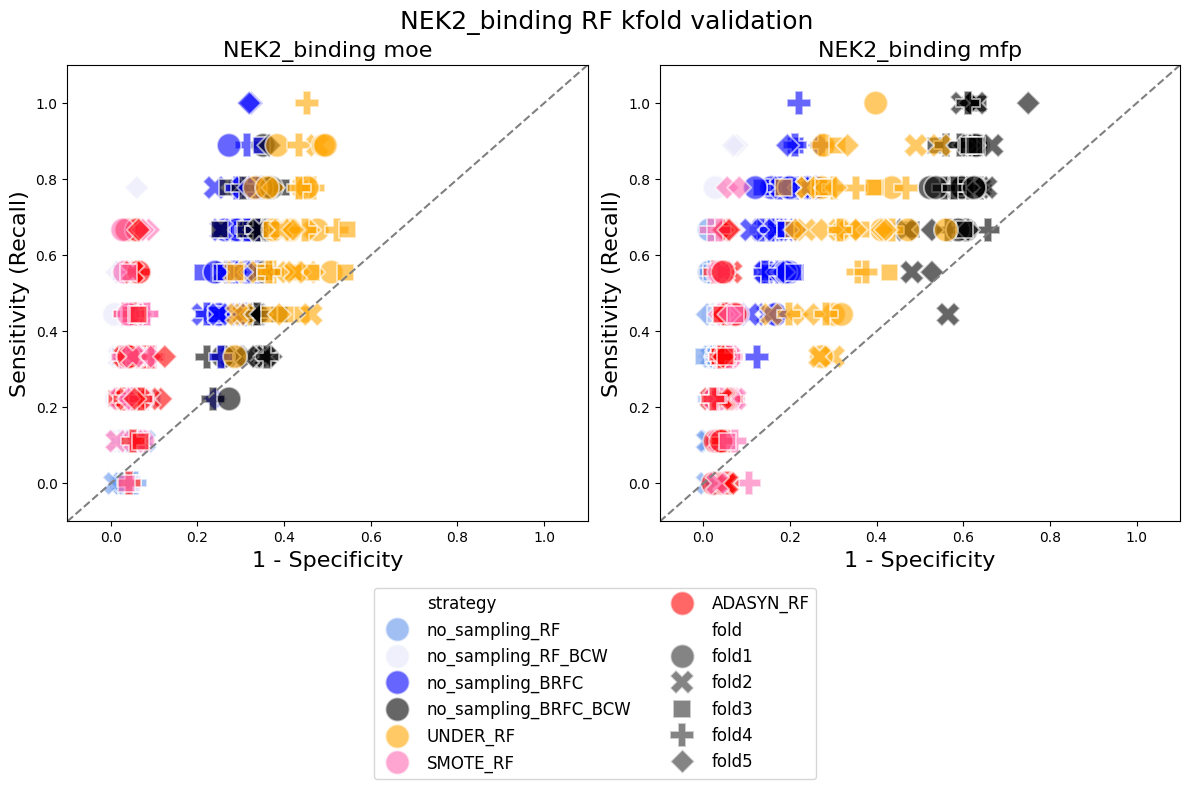

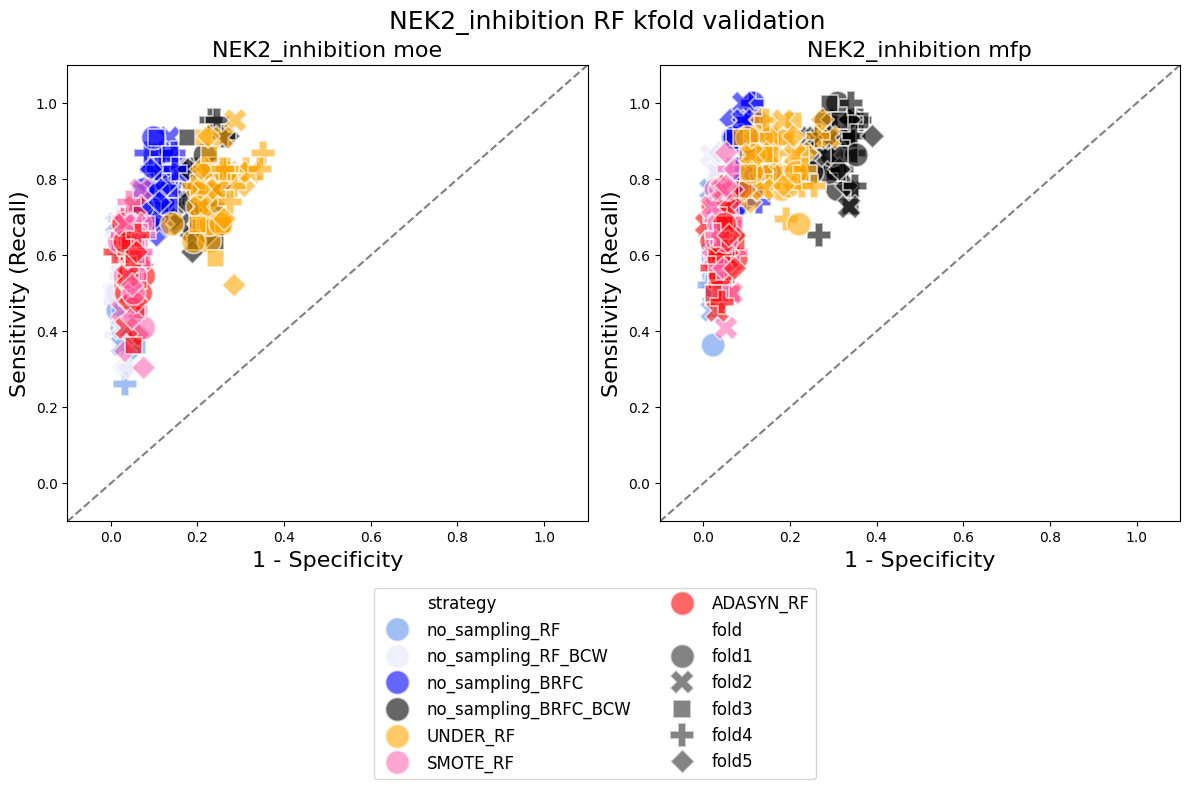

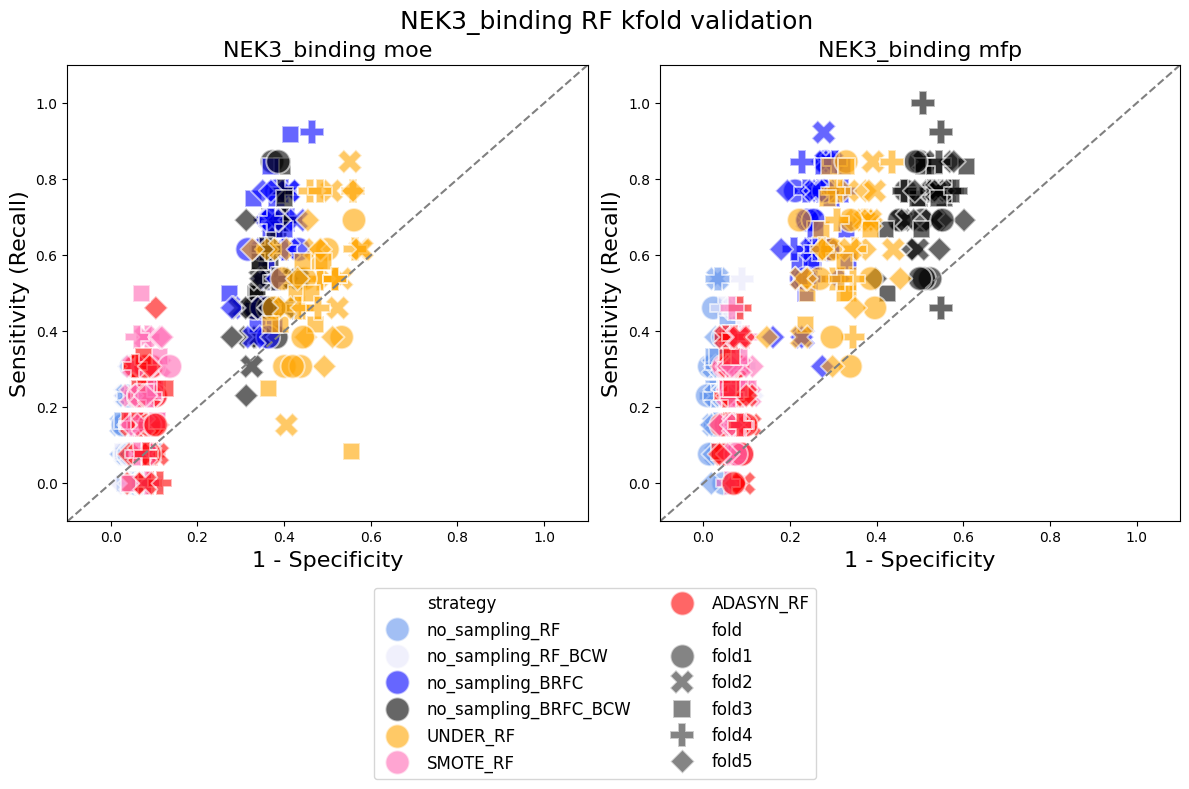

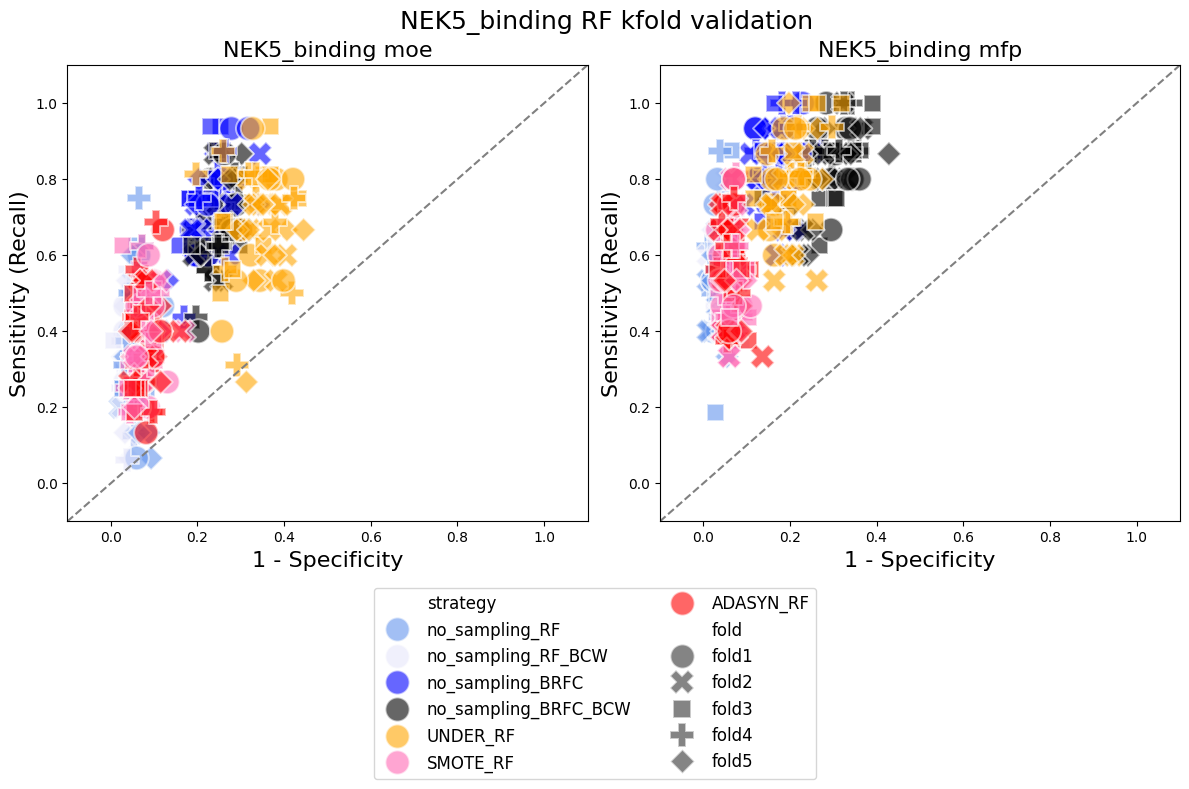

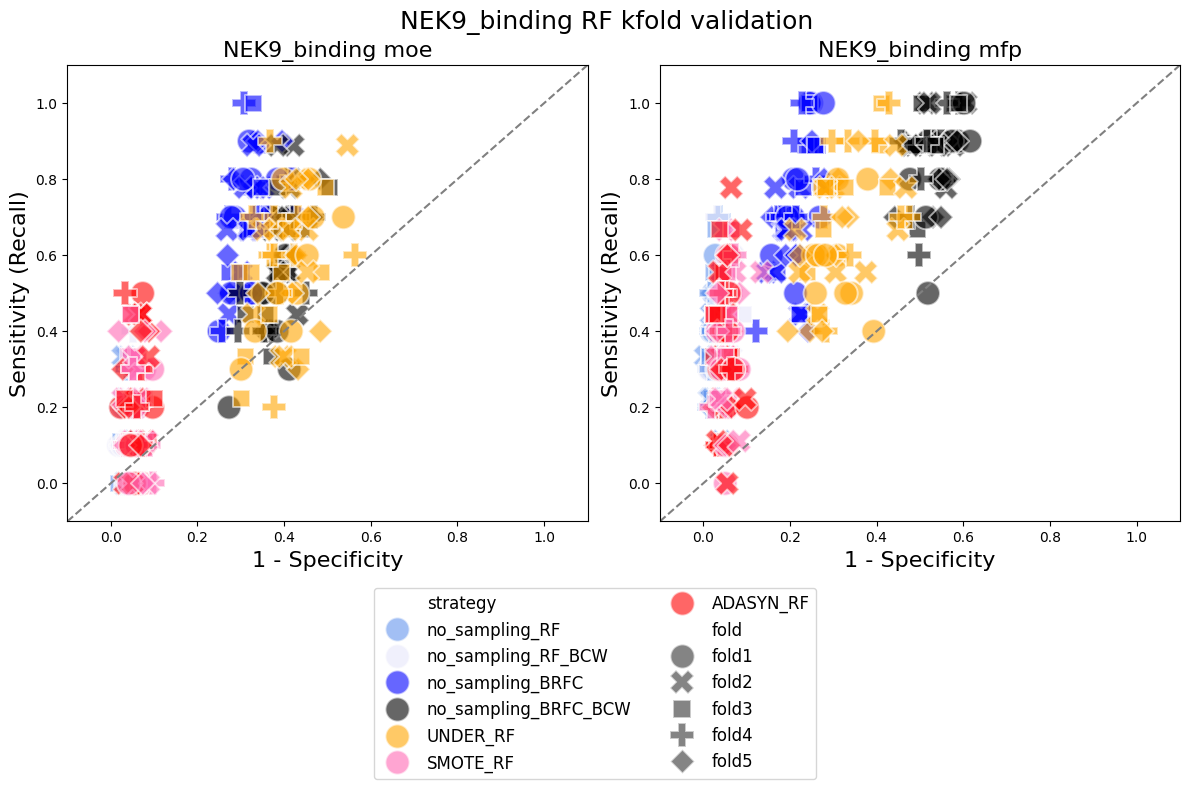

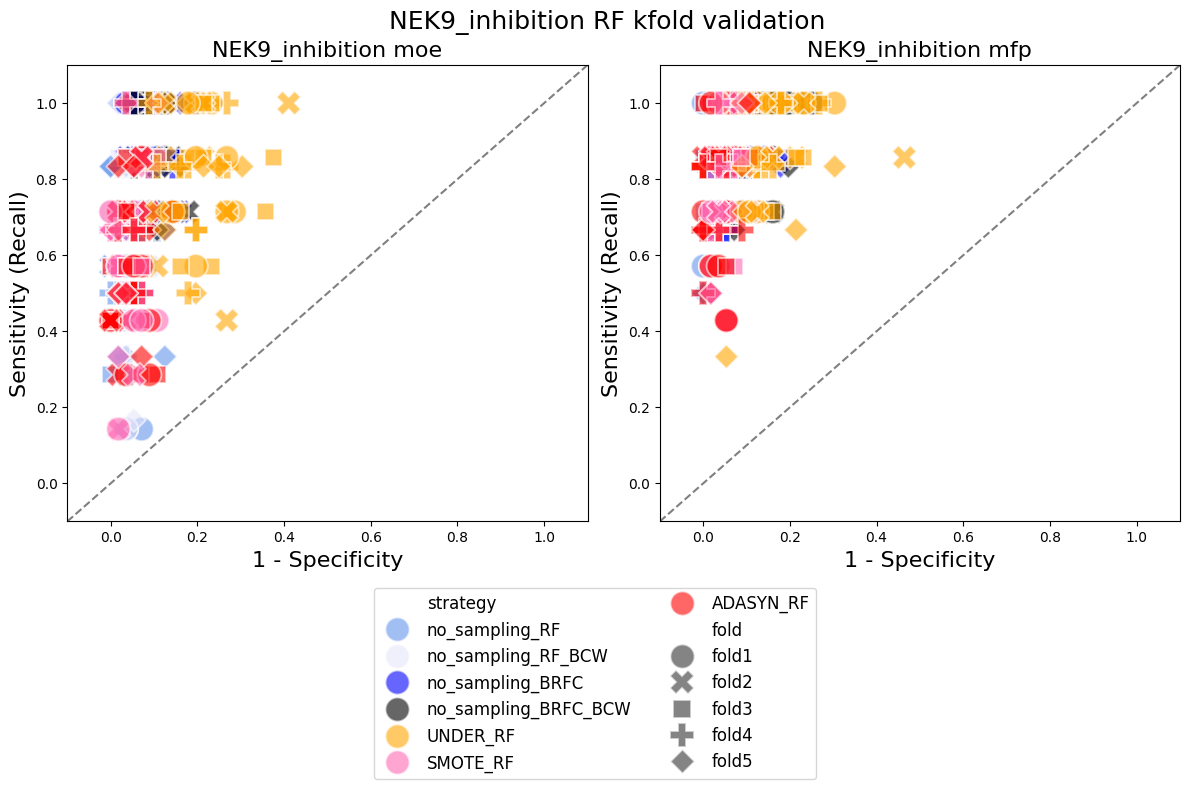

In [59]:
figs='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/rf_models/kfold_figs/'
for nek in total_rf['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = total_rf[total_rf['NEK']==nek]
    
    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} RF kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{figs}{nek}_RF_kfold.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

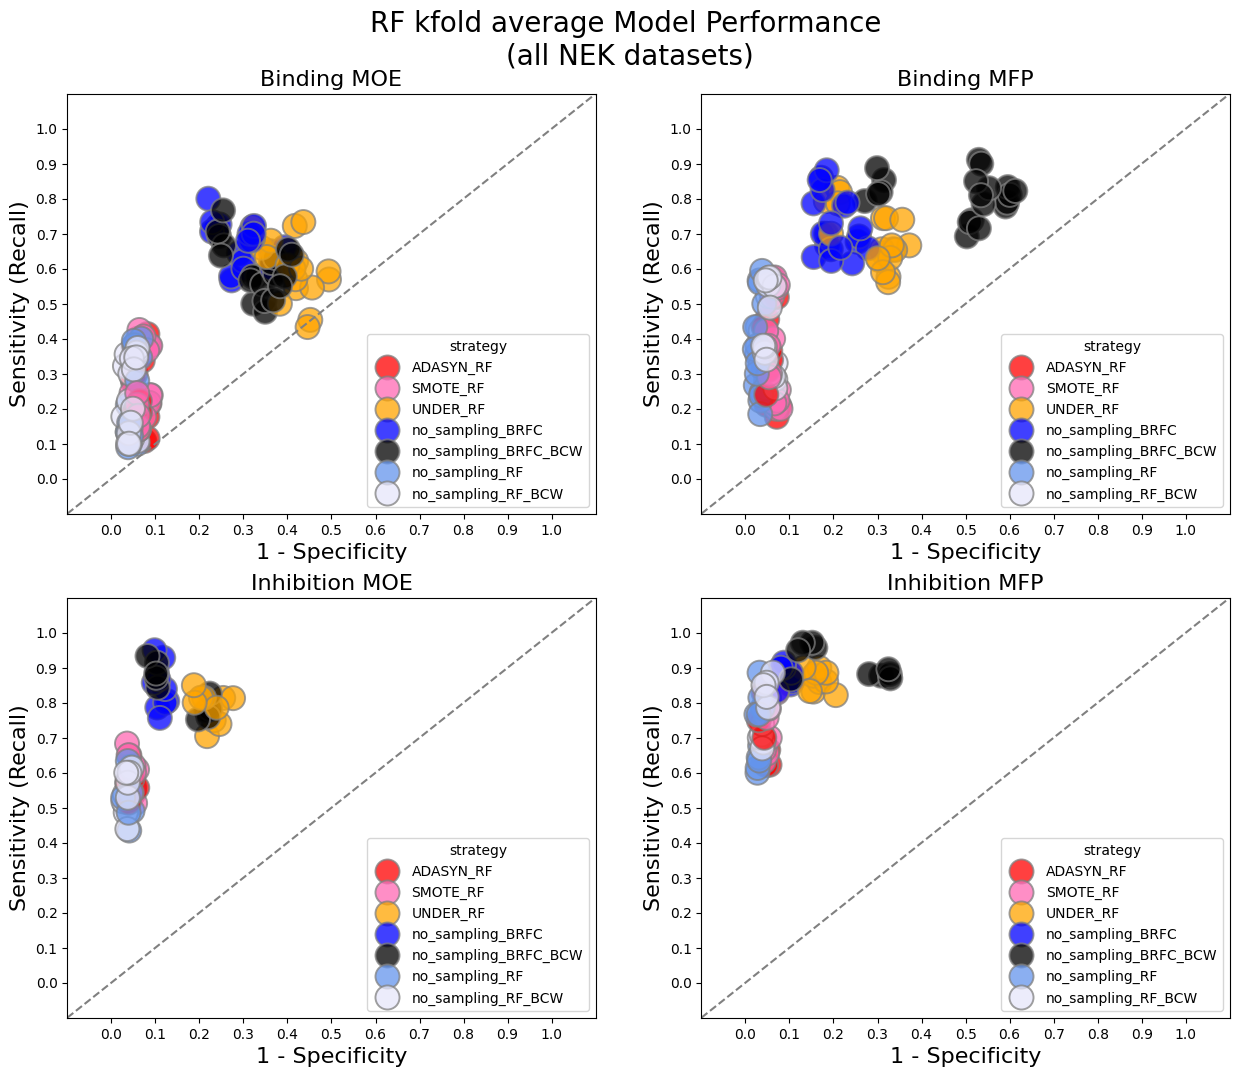

In [66]:

fig, axs = plt.subplots(2,2, figsize=(15,12))

for i, this_df in enumerate(list([binding, inhib])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    moe_avg = moe_df.groupby(['NEK', 'feat_type', 'strategy', 'fold'])[['recall', '1-specificity']].mean().reset_index()
    mfp_avg = mfp_df.groupby(['NEK', 'feat_type', 'strategy', 'fold'])[['recall', '1-specificity']].mean().reset_index()

    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy',
                   alpha=0.75,s=300, edgecolor='gray', ax=axs[i,0], palette=samp_palette)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy',
                   alpha=0.75, s=300,legend=True, ax=axs[i,1],edgecolor='gray', palette=samp_palette)
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        
        # axs[i, j].legend_.remove()
    
    axs[0, 0].set_title(f'Binding MOE', fontsize=16)
    axs[0, 1].set_title(f'Binding MFP', fontsize=16)
    axs[1, 0].set_title(f'Inhibition MOE', fontsize=16)
    axs[1, 1].set_title(f'Inhibition MFP', fontsize=16)

plt.suptitle(f'RF kfold average Model Performance \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
plt.savefig(f'{figs}RF_average_it.png', bbox_inches='tight')
plt.show();


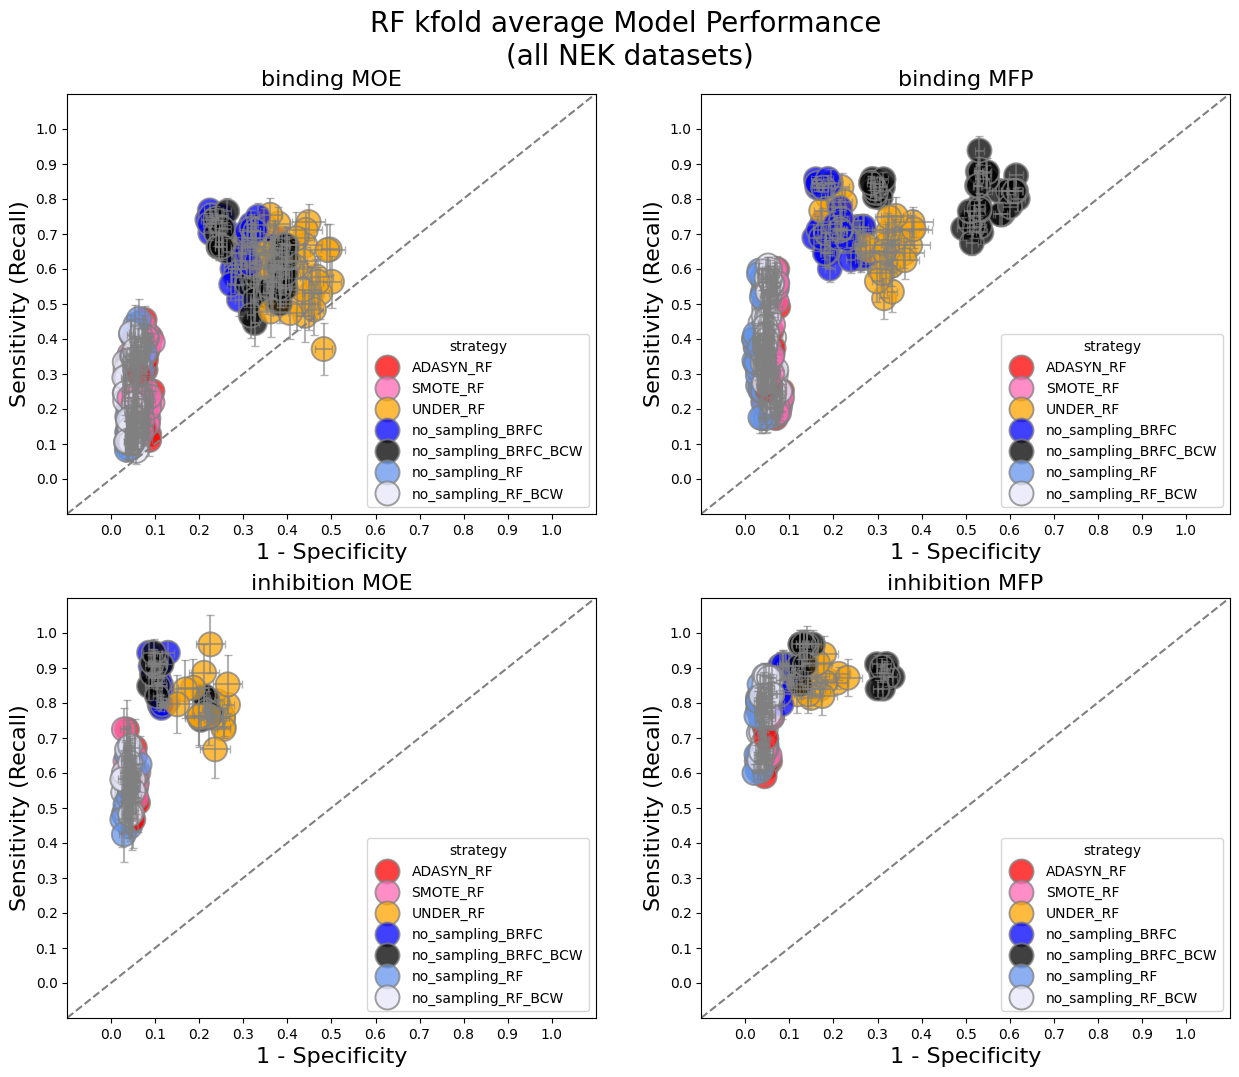

In [62]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([binding, inhib])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    moe_avg = moe_df.groupby(['NEK', 'feat_type', 'strategy', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    mfp_avg = mfp_df.groupby(['NEK', 'feat_type', 'strategy', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    moe_std = moe_avg.groupby(['NEK', 'feat_type', 'strategy' ])[['recall', '1-specificity']].std().reset_index()
    mfp_std = mfp_avg.groupby(['NEK', 'feat_type', 'strategy'])[['recall', '1-specificity']].std().reset_index()
    moe_merged = pd.merge(moe_avg, moe_std, on=['NEK', 'feat_type', 'strategy'], suffixes=('_avg', '_std'))
    mfp_merged = pd.merge(mfp_avg, mfp_std, on=['NEK', 'feat_type', 'strategy'], suffixes=('_avg', '_std'))
    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy',
                    palette=samp_palette, alpha=0.75, s=300, edgecolor='gray', ax=axs[i, 0])

    axs[i, 0].errorbar(x=moe_merged['1-specificity_avg'], y=moe_merged['recall_avg'],
                       xerr=moe_merged['1-specificity_std'], yerr=moe_merged['recall_std'],
                       fmt='none', ecolor='gray', alpha=0.6, capsize=3)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy',
                    palette=samp_palette, alpha=0.75, s=300, ax=axs[i, 1], edgecolor='gray')
    
    axs[i, 1].errorbar(x=mfp_merged['1-specificity_avg'], y=mfp_merged['recall_avg'],
                       xerr=mfp_merged['1-specificity_std'], yerr=mfp_merged['recall_std'],
                       fmt='none', ecolor='gray', alpha=0.6, capsize=3)
 
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        # axs[i, j].legend_.remove()
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{mfp_df["nek type"].iloc[0]} MFP', fontsize=16)

plt.suptitle(f'RF kfold average Model Performance \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
plt.savefig(f'{figs}RF_average_werr.png', bbox_inches='tight')
plt.show();


# GP 

In [16]:
gp_test = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv')
gp_train=pd.read_csv(f'{gp_results}GP_train_results_all_NEK_kfold_val.csv')
def extract_strategy(text, segment_index):
    pattern = rf'^(?:[^_]*_){{{segment_index-1}}}([^_]*)'
    match = re.search(pattern, text)
    return match.group(1) if match else None


gp_test['strategy'] = gp_test['model'].apply(lambda x: extract_strategy(x, 4))
# gp_test=gp_test.drop(columns='Unnamed: 0')
gp_test.to_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv',index=False)
gp_train['strategy'] = gp_train['model'].apply(lambda x: extract_strategy(x, 4))
# gp_train=gp_train.drop(columns='Unnamed: 0')
gp_train.to_csv(f'{gp_results}GP_train_results_all_NEK_kfold_val.csv',index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

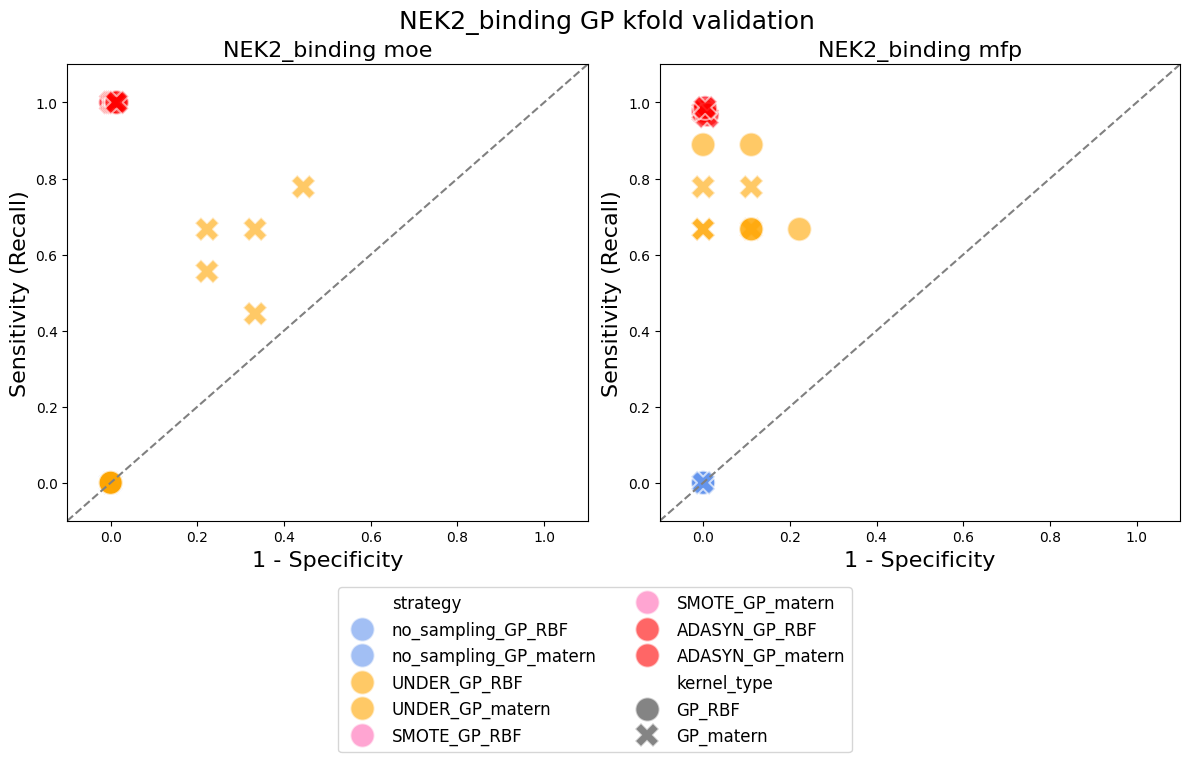

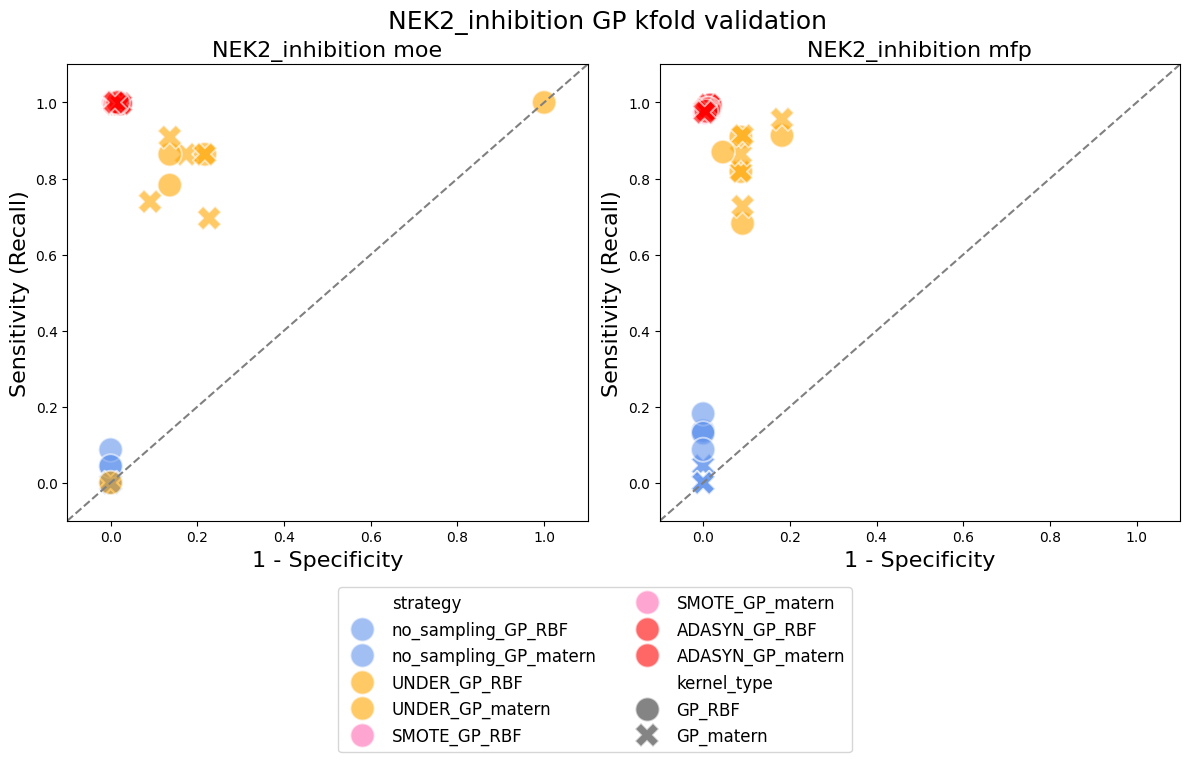

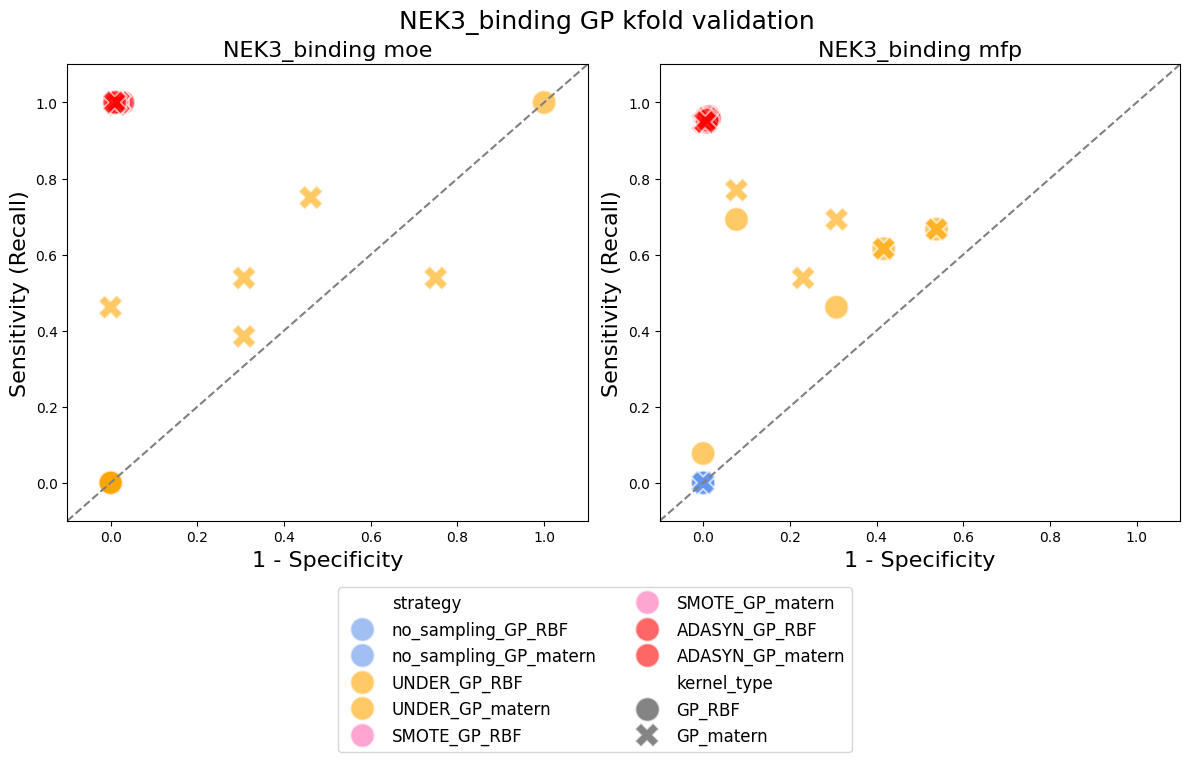

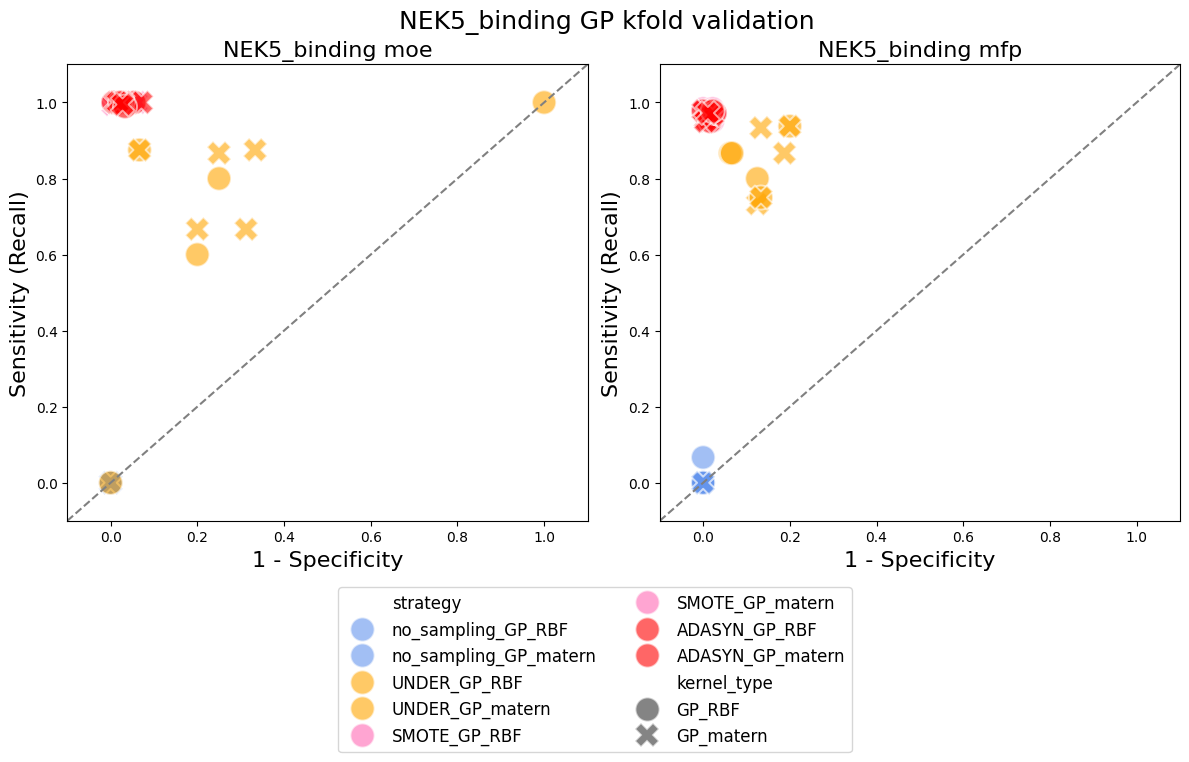

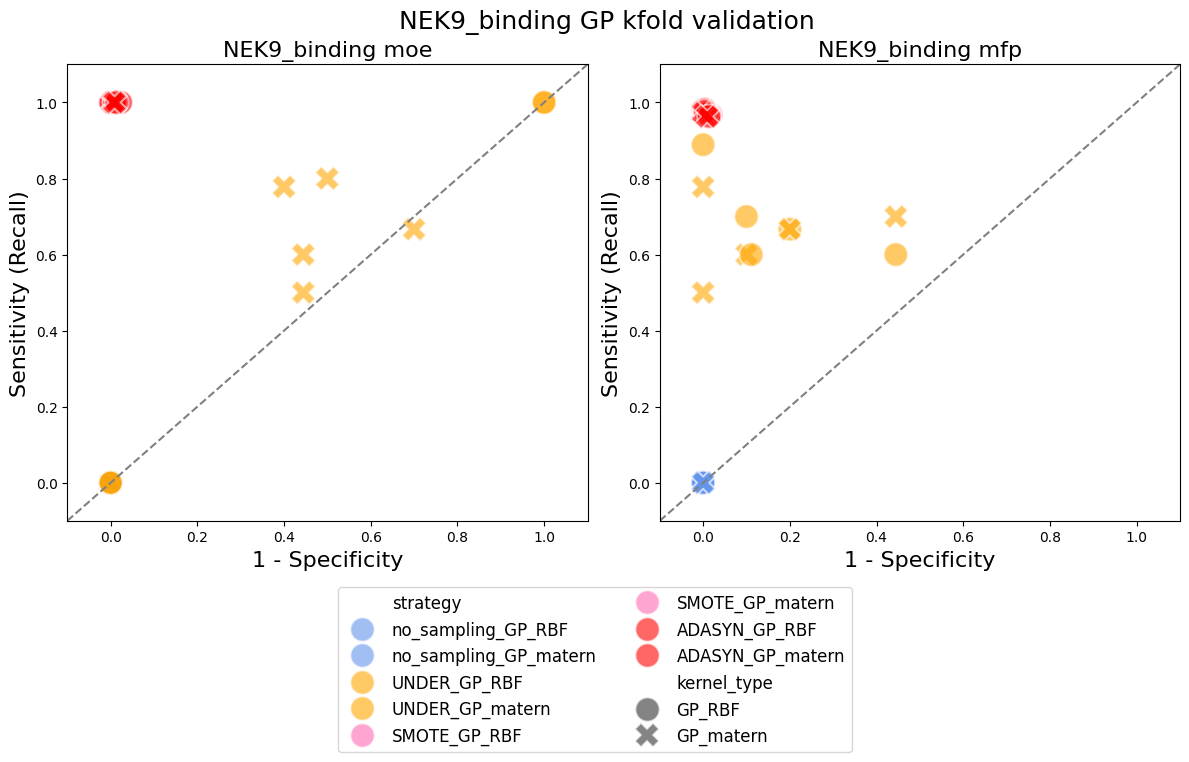

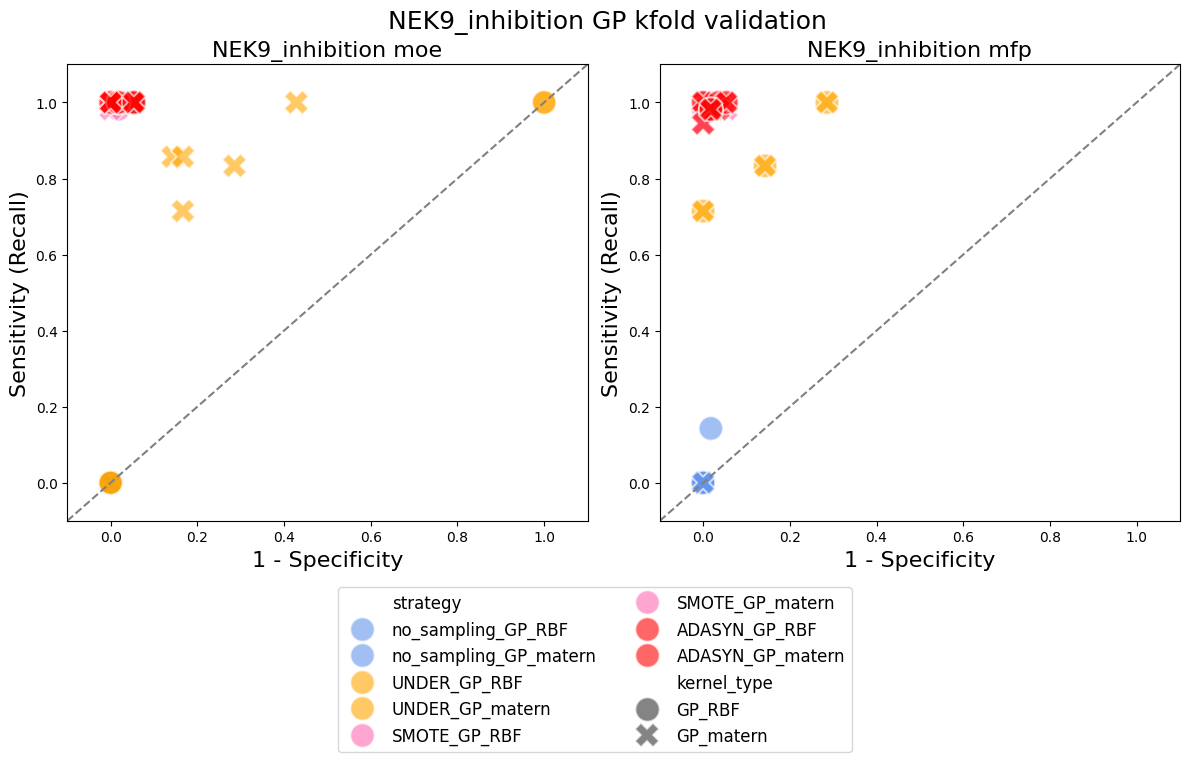

In [17]:
results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in gp['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp[gp['NEK']==nek]

    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{results_dir2}{nek}_GP_kfold_kernel_types.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

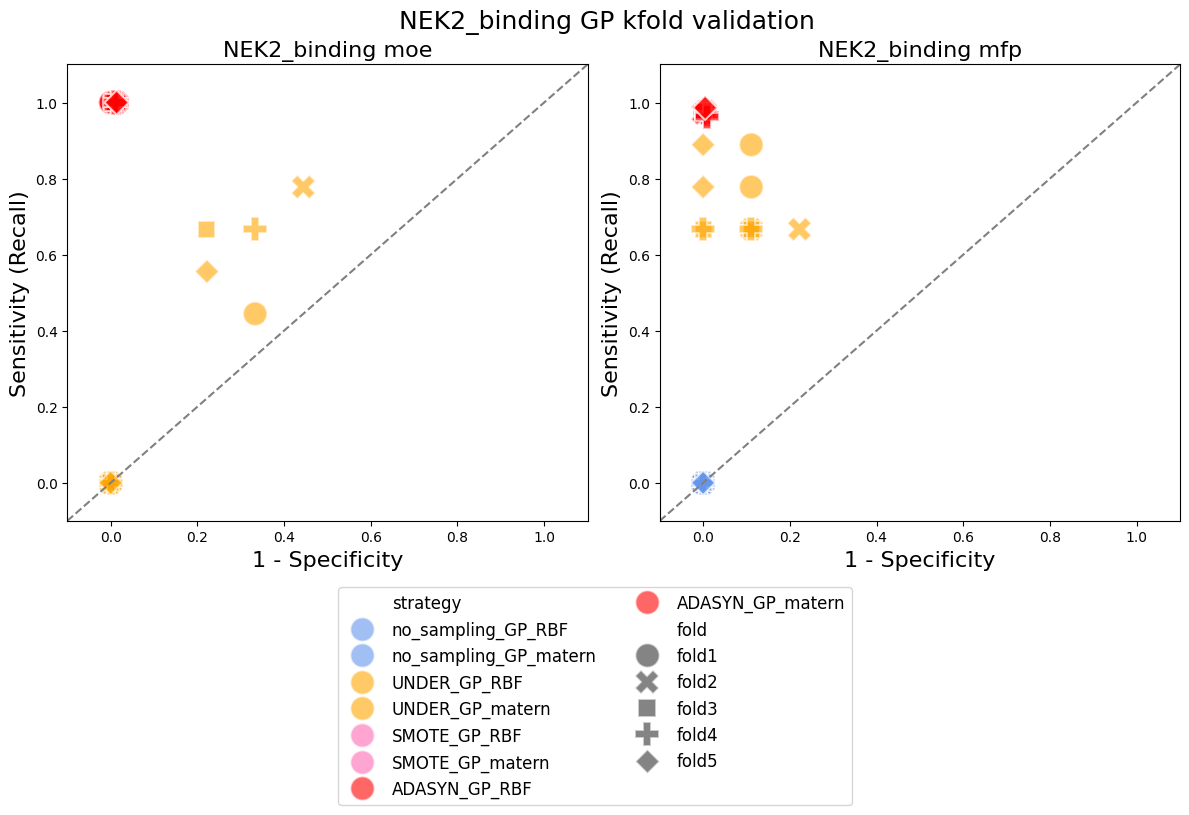

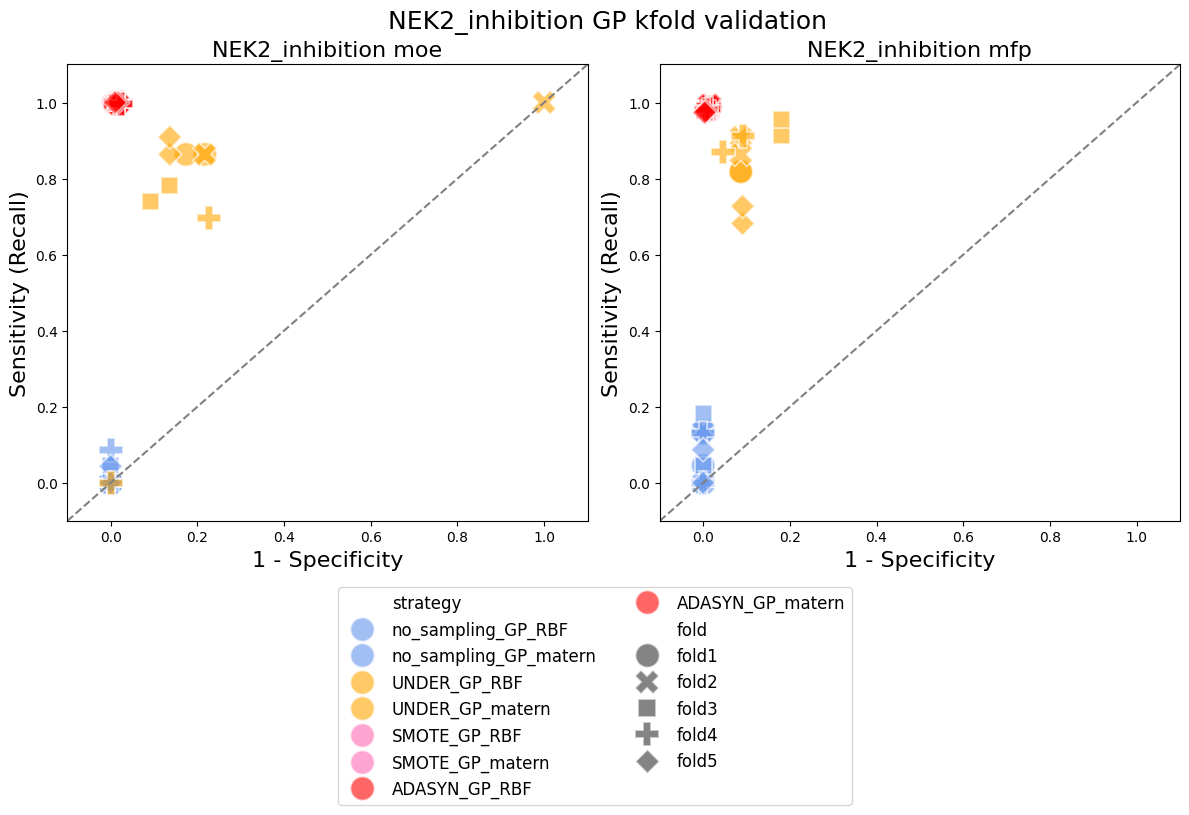

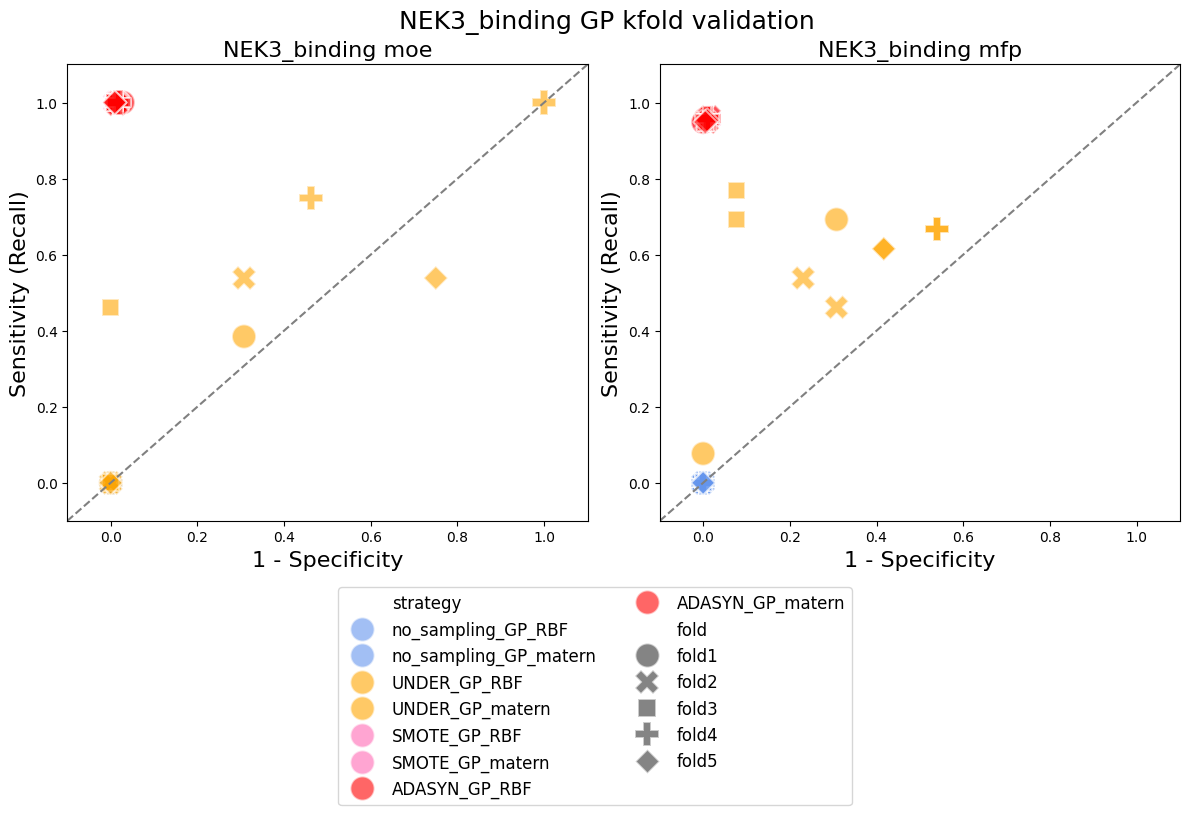

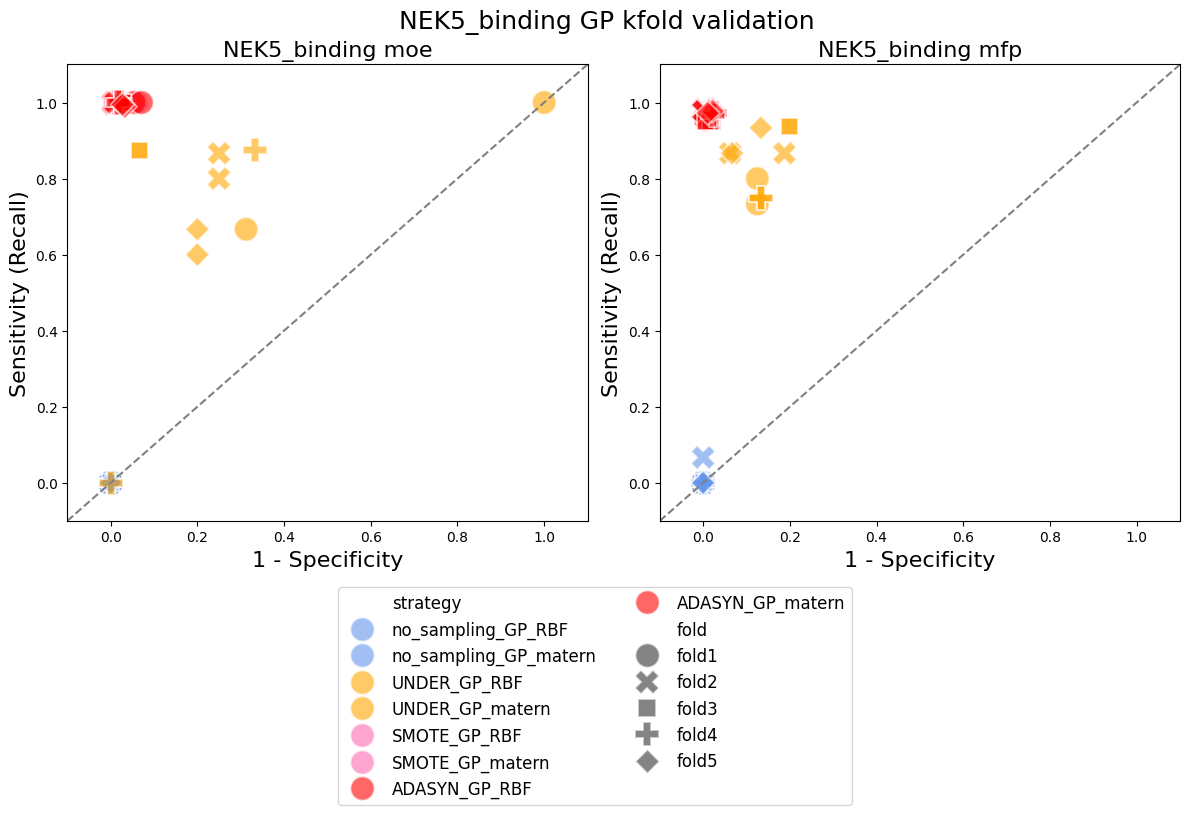

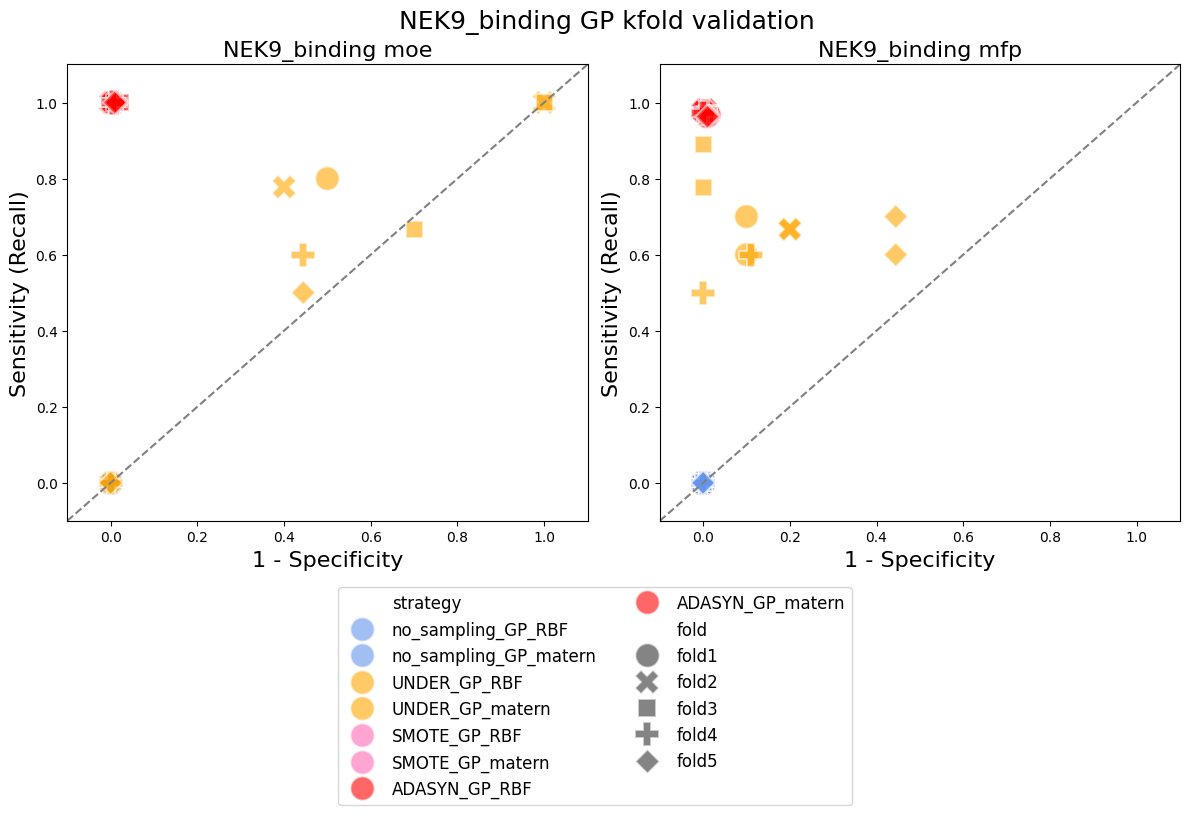

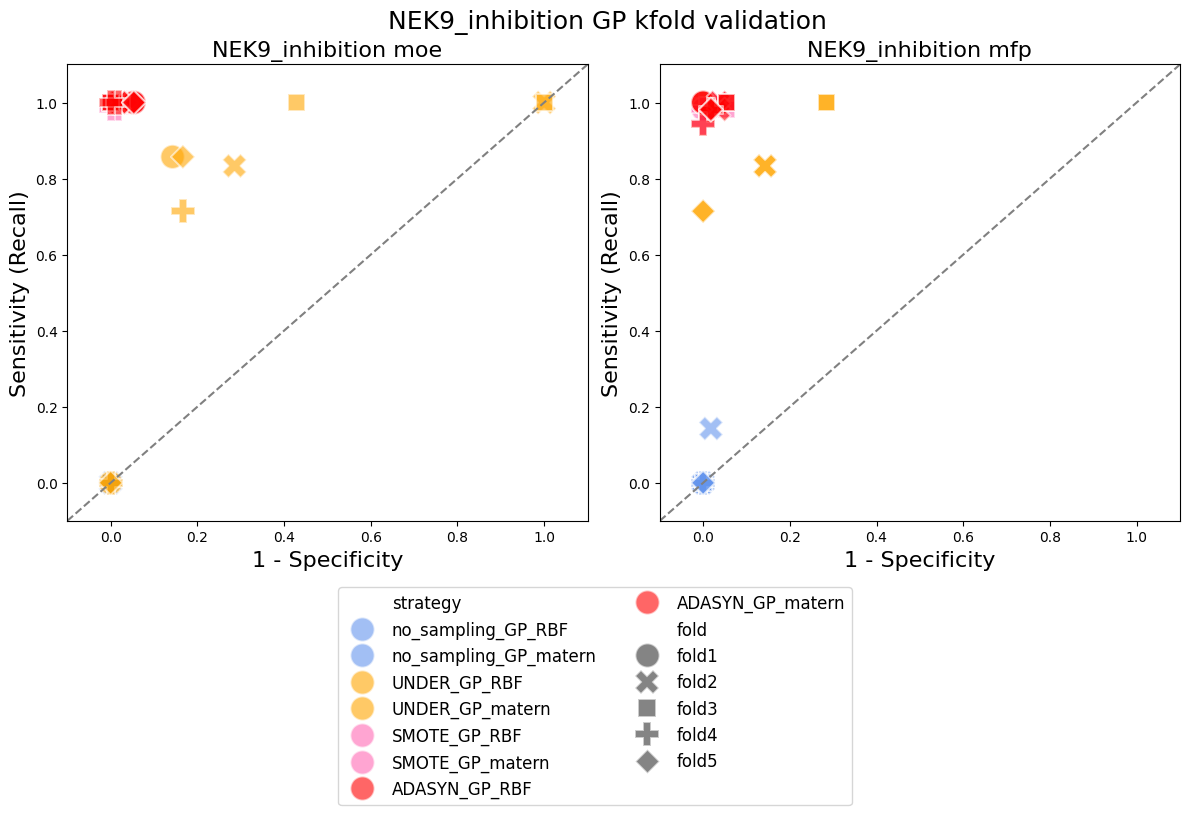

In [18]:
results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in gp['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp[gp['NEK']==nek]
    
    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{results_dir2}{nek}_GP_kfold.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

In [58]:
gp2 = gp.copy() 
gp2['strategy'] = gp2['strategy'].astype(str).apply(lambda x:x.split('_GP_')[0])
gp2

model              NEK     strategy  \
0       NEK2_binding_MOE_none_scaled_fold1_RBF     NEK2_binding  no_sampling   
1    NEK2_binding_MOE_none_scaled_fold1_matern     NEK2_binding  no_sampling   
2       NEK2_binding_MOE_none_scaled_fold2_RBF     NEK2_binding  no_sampling   
3    NEK2_binding_MOE_none_scaled_fold2_matern     NEK2_binding  no_sampling   
4       NEK2_binding_MOE_none_scaled_fold3_RBF     NEK2_binding  no_sampling   
..                                         ...              ...          ...   
475    NEK9_inhibition_MFP_ADASYN_fold3_matern  NEK9_inhibition       ADASYN   
476       NEK9_inhibition_MFP_ADASYN_fold4_RBF  NEK9_inhibition       ADASYN   
477    NEK9_inhibition_MFP_ADASYN_fold4_matern  NEK9_inhibition       ADASYN   
478       NEK9_inhibition_MFP_ADASYN_fold5_RBF  NEK9_inhibition       ADASYN   
479    NEK9_inhibition_MFP_ADASYN_fold5_matern  NEK9_inhibition       ADASYN   

    feat_type kernel_type   fold              cm    recall  specificity  \
0         MOE      GP_RBF  fold1  [216, 0, 9, 0]  0.000000     1.000000   
1         MOE   GP_matern  fold1  [216, 0, 9, 0]  0.000000     1.000000   
2         MOE      GP_RBF  fold2  [216, 0, 9, 0]  0.000000     1.000000   
3         MOE   GP_matern  fold2  [216, 0, 9, 0]  0.000000     1.000000   
4         MOE      GP_RBF  fold3  [216, 0, 9, 0]  0.000000     1.000000   
..        ...         ...    ...             ...       ...          ...   
475       MFP   GP_matern  fold3  [53, 3, 0, 54]  1.000000     0.946429   
476       MFP      GP_RBF  fold4  [55, 1, 1, 53]  0.981481     0.982143   
477       MFP   GP_matern  fold4  [56, 0, 3, 51]  0.944444     1.000000   
478       MFP      GP_RBF  fold5  [55, 1, 1, 53]  0.981481     0.982143   
479       MFP   GP_matern  fold5  [55, 1, 1, 53]  0.981481     0.982143   

     accuracy  precision        f1   ROC_AUC       MCC  balanced_accuracy  \
0    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
1    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
2    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
3    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
4    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
..        ...        ...       ...       ...       ...                ...   
475  0.972727   0.947368  0.972973  0.973214  0.946898           0.973214   
476  0.981818   0.981481  0.981481  0.981812  0.963624           0.981812   
477  0.972727   1.000000  0.971429  0.972222  0.946796           0.972222   
478  0.981818   0.981481  0.981481  0.981812  0.963624           0.981812   
479  0.981818   0.981481  0.981481  0.981812  0.963624           0.981812   

    modeling_type             set  1-specificity    nek type  
0              GP  foldvalidation       0.000000     binding  
1              GP  foldvalidation       0.000000     binding  
2              GP  foldvalidation       0.000000     binding  
3              GP  foldvalidation       0.000000     binding  
4              GP  foldvalidation       0.000000     binding  
..            ...             ...            ...         ...  
475            GP  foldvalidation       0.053571  inhibition  
476            GP  foldvalidation       0.017857  inhibition  
477            GP  foldvalidation       0.000000  inhibition  
478            GP  foldvalidation       0.017857  inhibition  
479            GP  foldvalidation       0.017857  inhibition  

[480 rows x 19 columns]

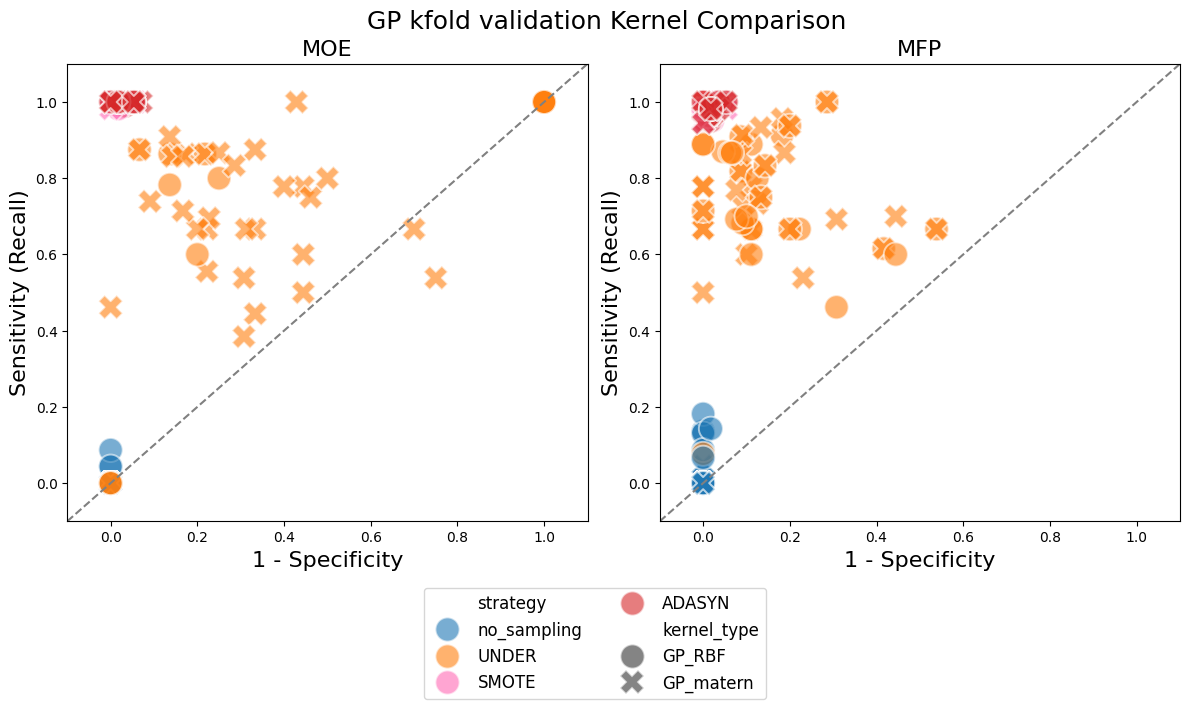

In [61]:

fig, axs = plt.subplots(1,2, figsize=(12,6))


moe_df = gp2[gp2['feat_type'] == 'MOE']
mfp_df =gp2[gp2['feat_type'] == 'MFP']
sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
               s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
              s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
plt.suptitle(f'GP kfold validation Kernel Comparison', fontsize=18, x=0.51, y =.96)
for i, ax in enumerate(axs): 
    axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
    axs[i].set_xlim(-0.1, 1.1)
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xlabel('1 - Specificity', fontsize=16)
    axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)

    
axs[0].set_title(f'MOE', fontsize=16)
axs[1].set_title(f'MFP', fontsize=16)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels,
           loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
axs[0].get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig(f'{results_dir2}GP_RBF_Matern.png',bbox_inches='tight')
plt.tight_layout()
plt.show();

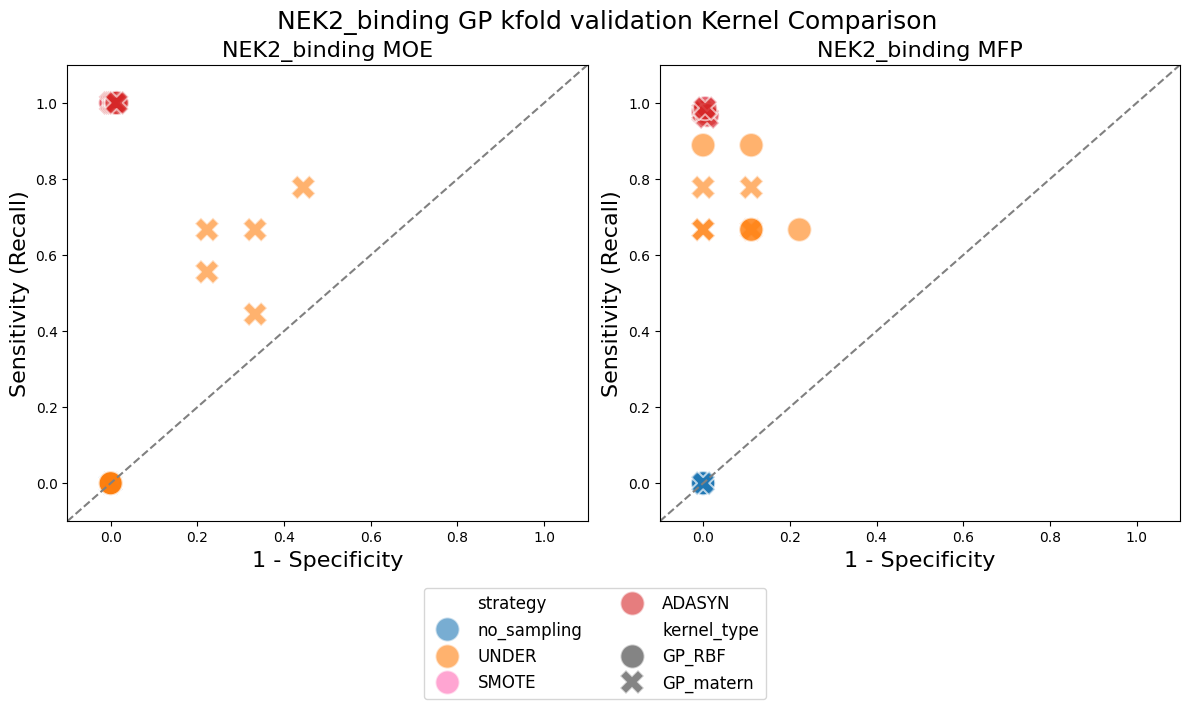

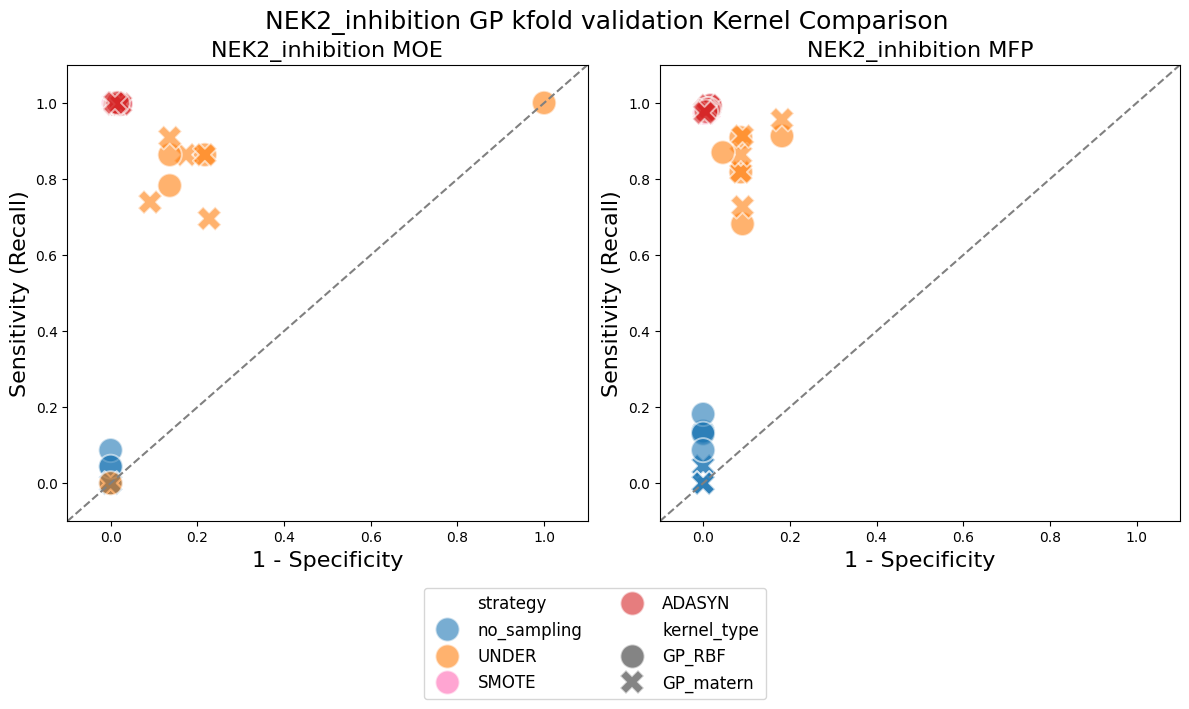

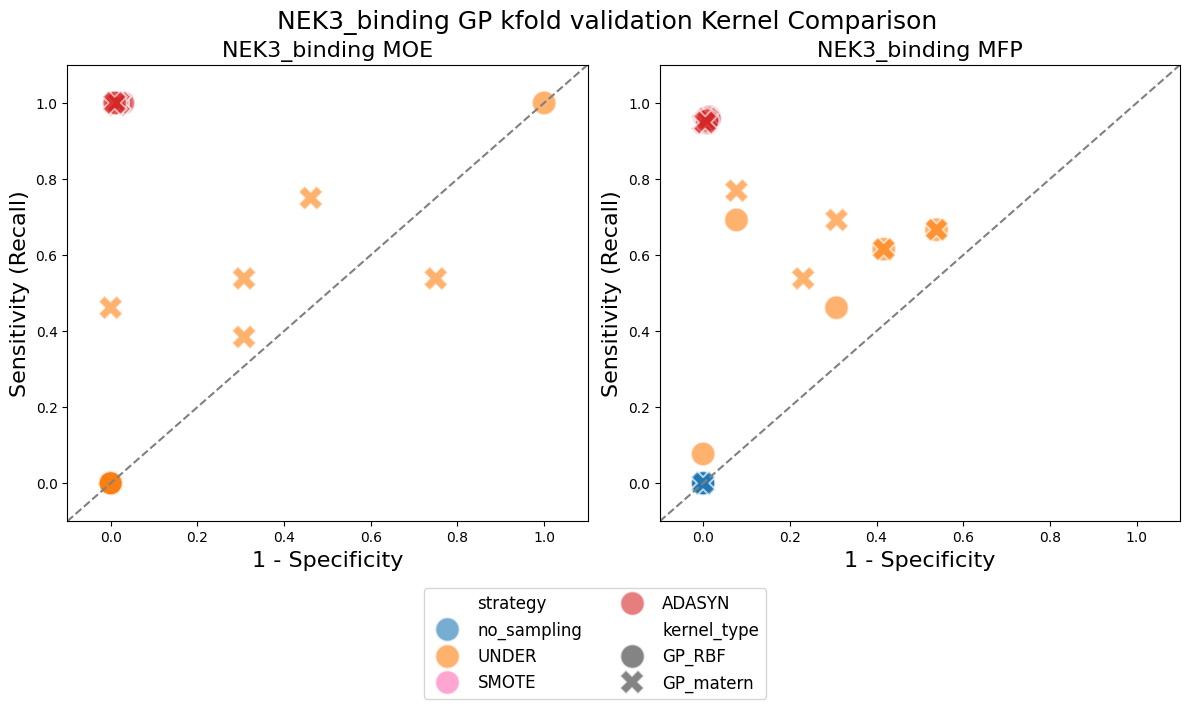

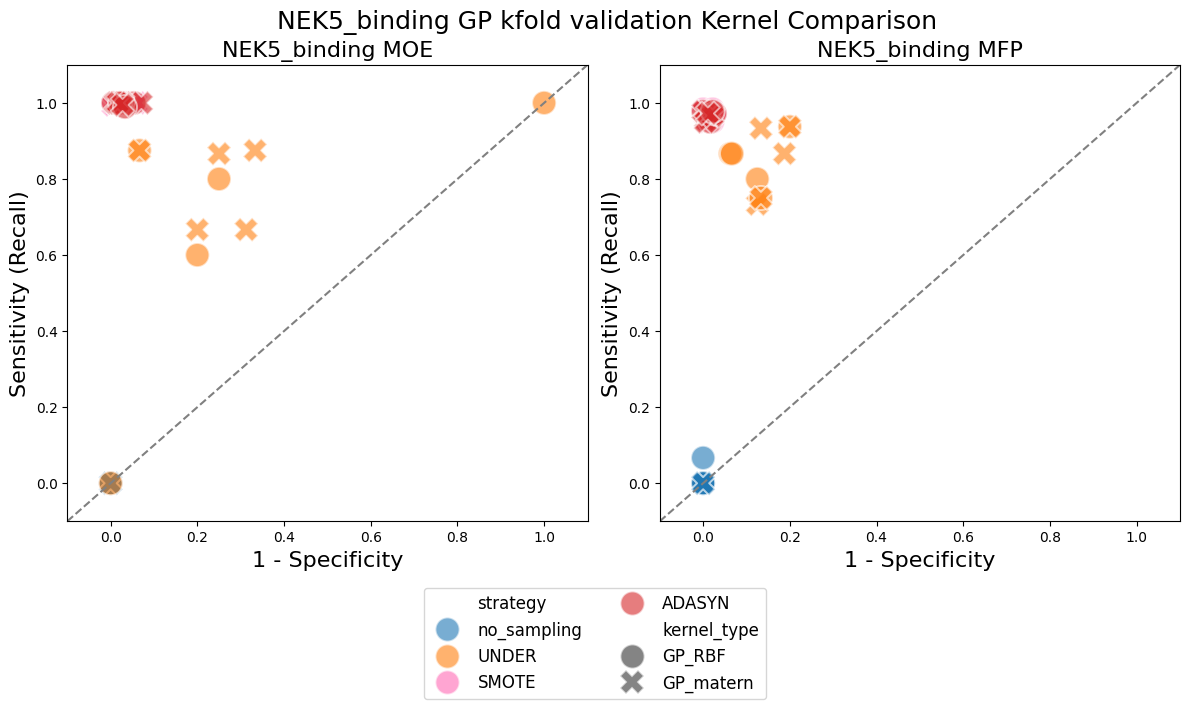

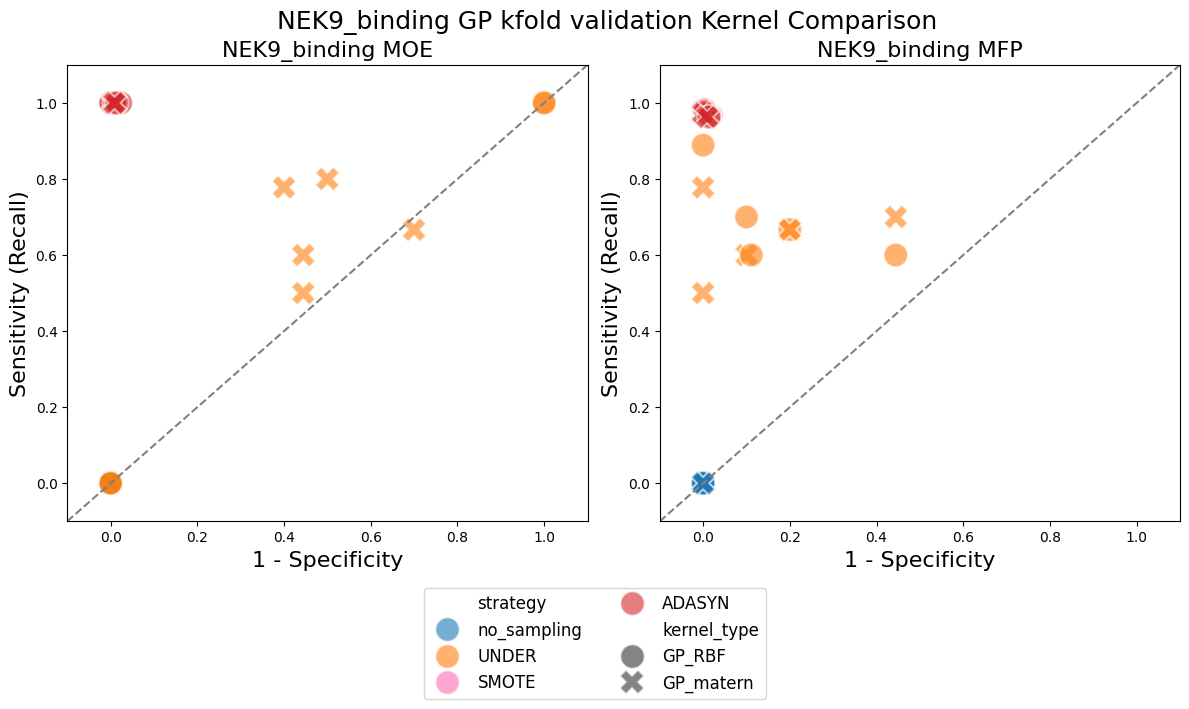

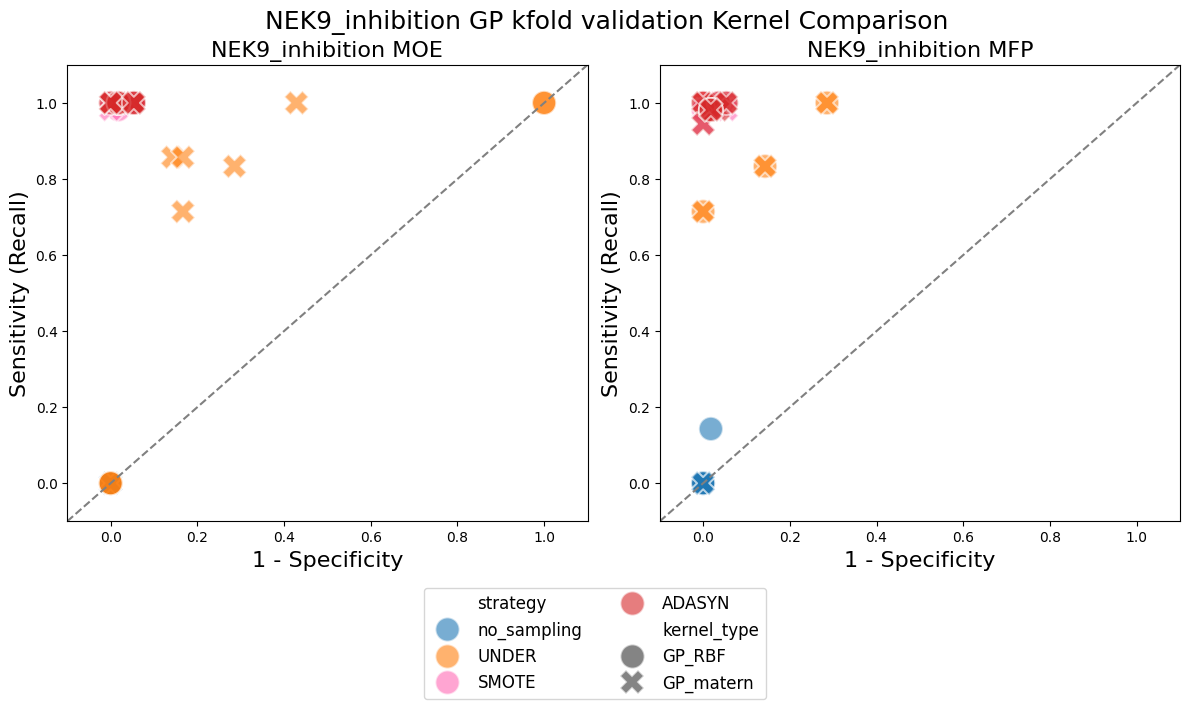

In [63]:
for nek in gp2['NEK'].unique():     
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp2[gp2['NEK'] == nek] 
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df =nek_df[nek_df['feat_type'] == 'MFP']
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation Kernel Comparison', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} MOE', fontsize=16)
    axs[1].set_title(f'{nek} MFP', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 

    plt.tight_layout()
    plt.show();

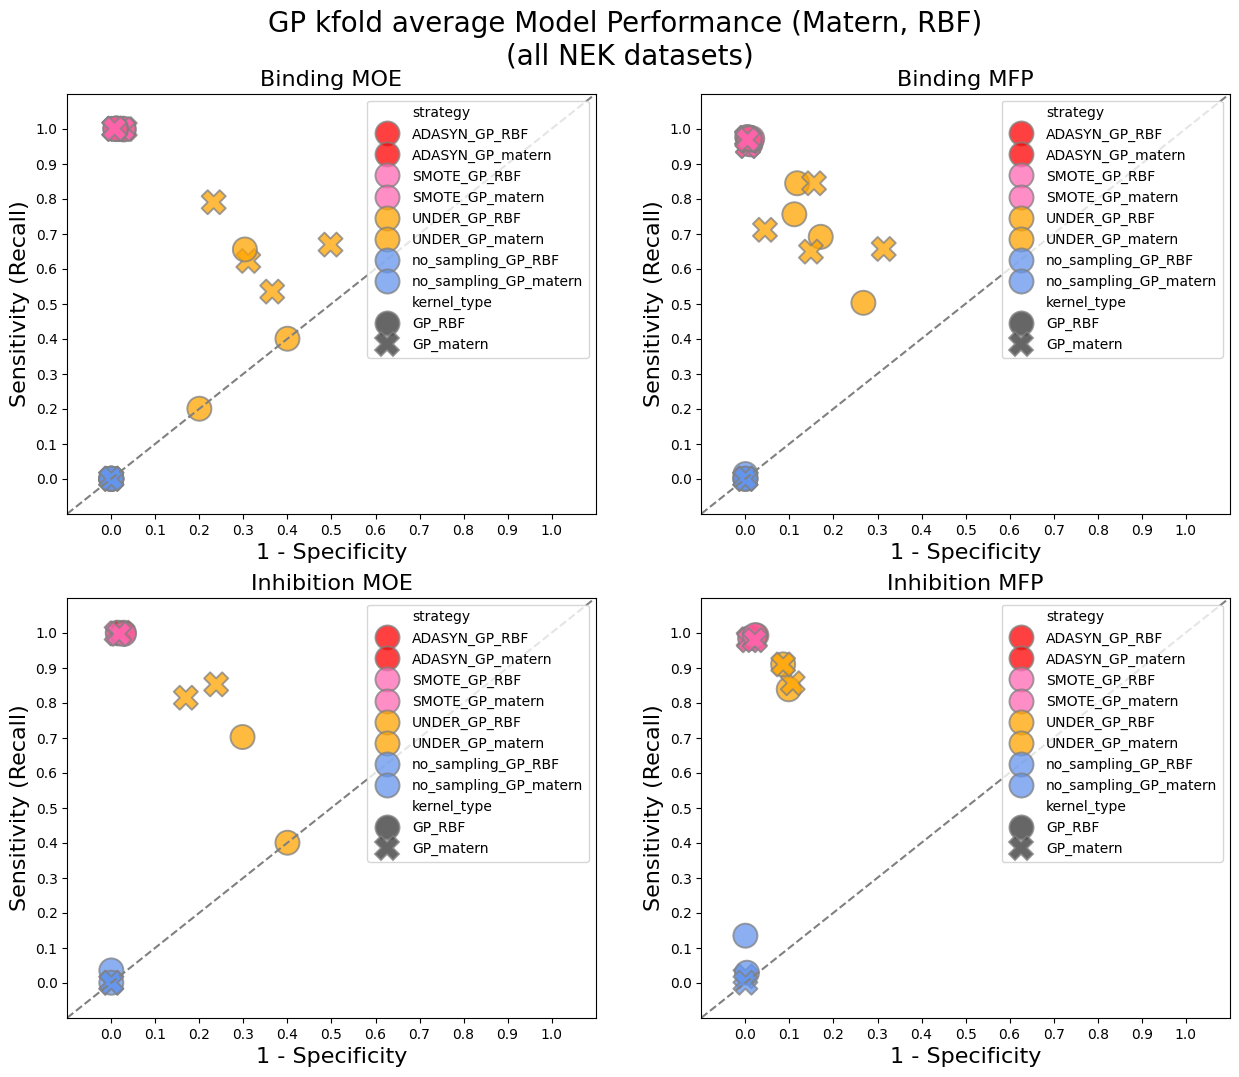

In [73]:
binding_avg_gp = binding_gp.groupby(['NEK','feat_type', 'strategy', 'kernel_type'])[['recall', '1-specificity']].mean()
binding_avg_df_gp=binding_avg_gp.reset_index()
inhib_avg_gp = inhib_gp.groupby(['NEK','feat_type', 'strategy','kernel_type'])[['recall', '1-specificity']].mean()
inhib_avg_df_gp=inhib_avg_gp.reset_index()
inhib_avg_df
fig, axs = plt.subplots(2,2, figsize=(15,12))

for i, this_df in enumerate(list([binding_avg_df_gp, inhib_avg_df_gp])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',  style='kernel_type',
                   alpha=0.75,s=300, edgecolor='gray', ax=axs[i,0], palette=samp_palette)
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   alpha=0.75, s=300,legend=True, ax=axs[i,1],edgecolor='gray', palette=samp_palette)
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        
        # axs[i, j].legend_.remove()
    
    axs[0, 0].set_title(f'Binding MOE', fontsize=16)
    axs[0, 1].set_title(f'Binding MFP', fontsize=16)
    axs[1, 0].set_title(f'Inhibition MOE', fontsize=16)
    axs[1, 1].set_title(f'Inhibition MFP', fontsize=16)

plt.suptitle(f'GP kfold average Model Performance (Matern, RBF) \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
plt.savefig(f'{results_dir2}GP_averages.png', bbox_inches='tight')
plt.show();


In [28]:
# RF kfold Results
rf = pd.read_csv(f'{rf_results}RF_test_results_all_NEK_kfold_val_10x.csv')
rf['1-specificity']=1-rf['specificity']
rf['nek type'] = rf['NEK'].astype(str).str.split('_').str[1]
rf=rf.replace('none_scaled', 'no_sampling')


rf_raw = rf[(rf['strategy'] == 'no_sampling') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'SMOTE', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 

rf_os= total_rf[(total_rf['strategy']=='SMOTE') | (total_rf['strategy']=='ADASYN')]
rf_avg = rf_os.groupby(['NEK', 'feat_type', 'strategy'])[['recall','specificity', '1-specificity']].mean()
rf_avg_revert = rf_avg.reset_index()
for nek in rf_avg_revert['NEK'].unique(): 
    nek_df = rf_avg_revert[rf_avg_revert['NEK']==nek]
    display(nek_df)

NEK feat_type strategy    recall  specificity  1-specificity
0  NEK2_binding       MFP   ADASYN  0.324444     0.953704       0.046296
1  NEK2_binding       MFP    SMOTE  0.346667     0.949630       0.050370
2  NEK2_binding       MOE   ADASYN  0.335556     0.947685       0.052315
3  NEK2_binding       MOE    SMOTE  0.344444     0.948426       0.051574

NEK feat_type strategy    recall  specificity  1-specificity
4  NEK2_inhibition       MFP   ADASYN  0.632925     0.952478       0.047522
5  NEK2_inhibition       MFP    SMOTE  0.669368     0.954458       0.045542
6  NEK2_inhibition       MOE   ADASYN  0.570870     0.945674       0.054326
7  NEK2_inhibition       MOE    SMOTE  0.572767     0.950632       0.049368

NEK feat_type strategy    recall  specificity  1-specificity
8   NEK3_binding       MFP   ADASYN  0.223077     0.929869       0.070131
9   NEK3_binding       MFP    SMOTE  0.218333     0.926565       0.073435
10  NEK3_binding       MOE   ADASYN  0.178718     0.917846       0.082154
11  NEK3_binding       MOE    SMOTE  0.176795     0.917485       0.082515

NEK feat_type strategy    recall  specificity  1-specificity
12  NEK5_binding       MFP   ADASYN  0.553500     0.936507       0.063493
13  NEK5_binding       MFP    SMOTE  0.550333     0.932775       0.067225
14  NEK5_binding       MOE   ADASYN  0.377333     0.921943       0.078057
15  NEK5_binding       MOE    SMOTE  0.365833     0.924026       0.075974

NEK feat_type strategy    recall  specificity  1-specificity
16  NEK9_binding       MFP   ADASYN  0.342222     0.949910       0.050090
17  NEK9_binding       MFP    SMOTE  0.358444     0.945827       0.054173
18  NEK9_binding       MOE   ADASYN  0.205111     0.942030       0.057970
19  NEK9_binding       MOE    SMOTE  0.216667     0.939802       0.060198

NEK feat_type strategy    recall  specificity  1-specificity
20  NEK9_inhibition       MFP   ADASYN  0.780952     0.957857       0.042143
21  NEK9_inhibition       MFP    SMOTE  0.799048     0.948214       0.051786
22  NEK9_inhibition       MOE   ADASYN  0.610476     0.953929       0.046071
23  NEK9_inhibition       MOE    SMOTE  0.598571     0.949643       0.050357

In [2]:
# RF kfold 
path2= '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_kfold_results/'

In [6]:
for nek in neks: 
    for i in range (4): 
        rf_it = pd.read_csv(f'{path2}RF_test_{nek}_{i}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>